In [6]:
# Importing necessary libraries for TensorFlow, pandas, numpy, and matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Importing the PyTorch library
import torch

# Importing additional libraries for data manipulation, visualization, and machine learning
import copy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

# Importing PyTorch modules for neural network implementation
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

# Ignoring warnings to enhance code cleanliness
import warnings
warnings.filterwarnings('ignore')
     


# utility functions

In [7]:
import torch
import numpy as np

def validate_model(model, val_dataset, tolerance=0.1, device='cuda'):
    model.eval()
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    val_losses = []
    val_accuracies = []
    reconstruction_errors = []

    with torch.no_grad():
        for seq_true in val_dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            # Compute loss (reconstruction error)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())

            # Compute accuracy
            abs_error = torch.abs(seq_true - seq_pred)
            correct = (abs_error < tolerance).float()
            accuracy = correct.mean().item() * 100
            val_accuracies.append(accuracy)

            # Store per-sample reconstruction errors (mean over sequence)
            mean_error = abs_error.mean(dim=-1).cpu().numpy()  # Mean over sequence length
            reconstruction_errors.extend(mean_error)

    avg_val_loss = np.mean(val_losses)
    avg_val_acc = np.mean(val_accuracies)
    reconstruction_errors = np.array(reconstruction_errors)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.2f}%")
    print(f"Mean Reconstruction Error: {np.mean(reconstruction_errors):.4f}")
    print(f"Std Reconstruction Error: {np.std(reconstruction_errors):.4f}")

    return reconstruction_errors


In [8]:
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[0].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()

In [9]:
import matplotlib.pyplot as plt

def plot_convergence(history, save_path='convergence_plot.png'):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (L1)')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Convergence')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


In [10]:
import torch
import numpy as np
import copy

def train_model(model, train_dataset, val_dataset, n_epochs, save_path, patience=10, tolerance=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_losses = []
        train_accuracies = []

        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            # Compute loss
            loss = criterion(seq_pred, seq_true)

            # Compute accuracy
            abs_error = torch.abs(seq_true - seq_pred)
            correct = (abs_error < tolerance).float()
            accuracy = correct.mean().item() * 100

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accuracies.append(accuracy)

        model.eval()
        val_losses = []
        val_accuracies = []
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)

                abs_error = torch.abs(seq_true - seq_pred)
                correct = (abs_error < tolerance).float()
                accuracy = correct.mean().item() * 100

                val_losses.append(loss.item())
                val_accuracies.append(accuracy)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_acc = np.mean(train_accuracies)
        val_acc = np.mean(val_accuracies)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%')

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print("Saving best model.")
        else:
            patience_counter += 1
            print(f"No improvement. Patience {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

        if epoch == 1 or epoch % 5 == 0:
            plot_input_reconstruction(model, val_dataset, epoch)

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model.eval(), history


In [14]:
from torch.utils.data import DataLoader

def train_model_v2(model, train_dataset, val_dataset, n_epochs, save_path, patience=10, tolerance=0.2, batch_size=32):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    criterion = torch.nn.MSELoss().to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_losses = []
        train_accuracies = []

        for batch in train_loader:
            for sample in batch:  # sample shape: [seq_len, n_features]
                optimizer.zero_grad()
                sample = sample.to(device)
                output = model(sample)
                loss = criterion(output, sample)

                abs_error = torch.abs(sample - output)
                correct = (abs_error < tolerance).float()
                accuracy = correct.mean().item() * 100

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                train_losses.append(loss.item())
                train_accuracies.append(accuracy)

        model.eval()
        val_losses = []
        val_accuracies = []
        with torch.no_grad():
            for batch in val_loader:
                for sample in batch:
                    sample = sample.to(device)
                    output = model(sample)
                    loss = criterion(output, sample)

                    abs_error = torch.abs(sample - output)
                    correct = (abs_error < tolerance).float()
                    accuracy = correct.mean().item() * 100

                    val_losses.append(loss.item())
                    val_accuracies.append(accuracy)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_acc = np.mean(train_accuracies)
        val_acc = np.mean(val_accuracies)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step()

        print(f'Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print("Saving best model.")
        else:
            patience_counter += 1
            print(f"No improvement. Patience {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

    model.load_state_dict(best_model_wts)
    return model.eval(), history


In [11]:
def get_reconstruction_errors(model, dataset, threshold, device='cuda'):
    model.eval()
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    errors = []
    predictions = []

    with torch.no_grad():
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            abs_error = torch.abs(seq_true - seq_pred)
            mean_error = abs_error.mean(dim=-1).cpu().numpy()  # mean over sequence
            errors.extend(mean_error)

            # Predict anomaly if error > threshold
            is_anomaly = mean_error > threshold
            predictions.extend(is_anomaly)

    return np.array(errors), np.array(predictions)

# Exploratory Data Analysis and Visualization of ECG Data

## data loading

In [12]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## EDA

In [13]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,...,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,...,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,...,-1.087720,-1.588237,-2.146835,-2.730750,-3.031224,-2.868603,-2.154560,-1.658289,-1.596809,0.000000
50%,-0.297541,-1.661892,-2.586129,-3.388210,-3.469899,-2.947061,-2.285427,-1.750084,-1.422457,-0.910384,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.568443,1.000000
75%,0.499909,-0.677998,-1.514187,-2.235690,-2.531153,-2.398797,-1.823480,-1.484107,-1.063592,-0.476477,...,1.169392,1.238651,1.264379,1.234408,1.033957,0.945027,0.951621,1.002628,0.271635,1.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,1.000000


In [14]:
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
136    0
137    0
138    0
139    0
140    0
Length: 141, dtype: int64

In [15]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
136    float64
137    float64
138    float64
139    float64
140    float64
Length: 141, dtype: object

In [16]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
     

In [17]:
print(new_columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 'target']


In [18]:
df.target.value_counts()

target
1.0    2919
0.0    2079
Name: count, dtype: int64

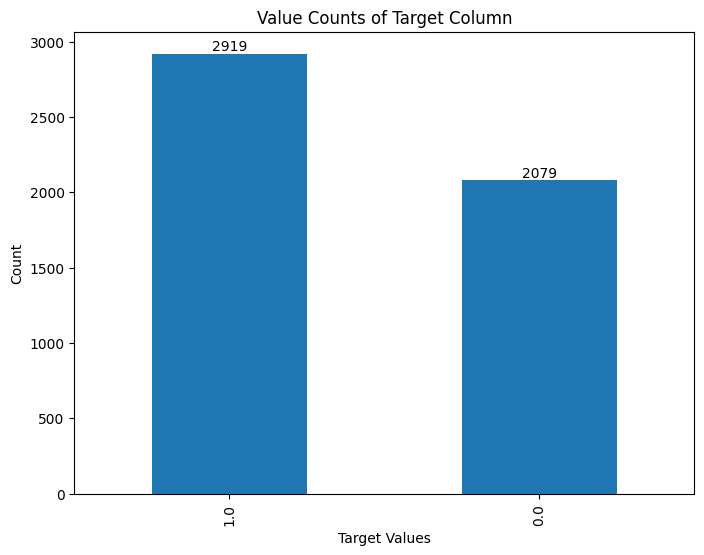

In [19]:
value_counts = df['target'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')
plt.title('Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()
     


In [20]:

classes = df.target.unique()

def plot_ecg(data, class_name, ax, n_steps=10):
    # Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='black', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    # Set the title
    ax.set_title(class_name)

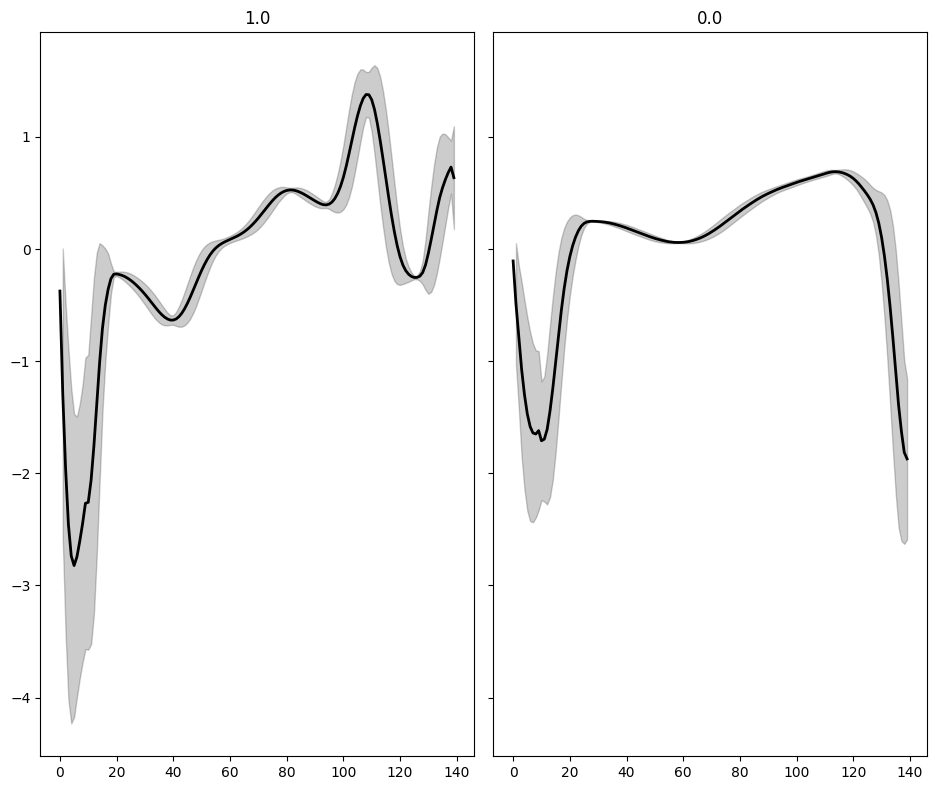

In [21]:

# Plotting setup
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_ecg(data, cls, ax)  

# Adjust layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()

# Data preprocessing and Splitting 

In [22]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [23]:
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(2079, 140)

In [24]:
# Splitting the Dataset

# Initial Train-Validation Split:
# The dataset 'normal_df' is divided into training and validation sets.
# 15% of the data is allocated to the validation set.

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)

# Further Splitting for Validation and Test:
# The validation set obtained in the previous step is further split into validation and test sets.
# 33% of the validation set is allocated to the test set.
# The same 'random_state=42' is used for consistency in randomization.

val_df, test_df = train_test_split(
  val_df,
  test_size=0.30,
  random_state=42
)

In [25]:
# Function to Create a Dataset
def create_dataset(df):
    # Convert DataFrame to a list of sequences, each represented as a list of floats
    sequences = df.astype(np.float32).to_numpy().tolist()

    # Convert sequences to PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features
     


In [26]:
# Create the training dataset from train_df
train_dataset, seq_len, n_features = create_dataset(train_df)

# Create the validation dataset from val_df
val_dataset, _, _ = create_dataset(val_df)

# Create the test dataset for normal cases from test_df
test_normal_dataset, _, _ = create_dataset(test_df)

# Create the test dataset for anomalous cases from anomaly_df
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)
     


In [25]:
print(seq_len , n_features)

140 1


# Modeling 

## model 1 : lstm auto encoder

### moel architecture

In [27]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))
     

In [28]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)
     

In [29]:
class Autoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Autoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)

In [31]:
device

device(type='cuda')

### Training

Epoch 1: Train Loss 83.3767, Val Loss 55.7255, Train Acc 14.61%, Val Acc 25.95%
Saving best model.


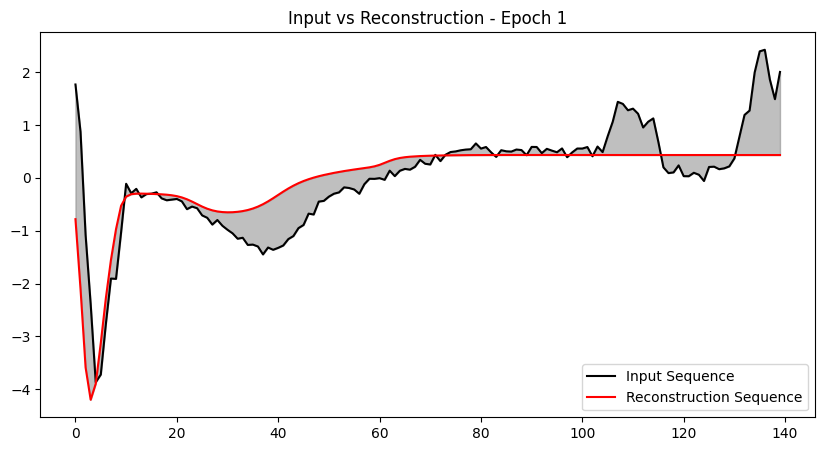

Epoch 2: Train Loss 55.2402, Val Loss 53.9850, Train Acc 27.40%, Val Acc 28.73%
Saving best model.
Epoch 3: Train Loss 47.6897, Val Loss 40.7833, Train Acc 30.14%, Val Acc 33.33%
Saving best model.
Epoch 4: Train Loss 43.3844, Val Loss 40.1428, Train Acc 32.92%, Val Acc 34.05%
Saving best model.
Epoch 5: Train Loss 42.4121, Val Loss 41.1838, Train Acc 33.63%, Val Acc 33.72%
No improvement. Patience 1/10


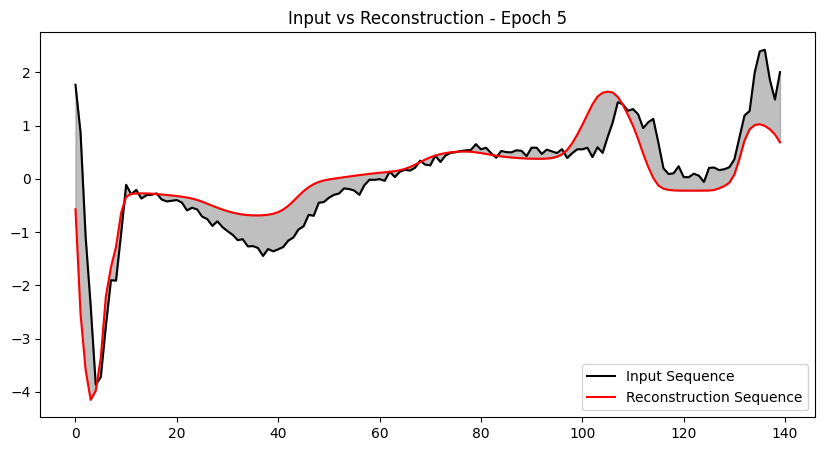

Epoch 6: Train Loss 42.3510, Val Loss 42.5226, Train Acc 33.71%, Val Acc 33.35%
No improvement. Patience 2/10
Epoch 7: Train Loss 42.1426, Val Loss 42.0704, Train Acc 33.80%, Val Acc 33.25%
No improvement. Patience 3/10
Epoch 8: Train Loss 41.9574, Val Loss 42.2473, Train Acc 33.94%, Val Acc 33.36%
No improvement. Patience 4/10
Epoch 9: Train Loss 41.8852, Val Loss 41.6900, Train Acc 34.03%, Val Acc 33.47%
No improvement. Patience 5/10
Epoch 10: Train Loss 41.6424, Val Loss 41.6963, Train Acc 34.19%, Val Acc 33.32%
No improvement. Patience 6/10


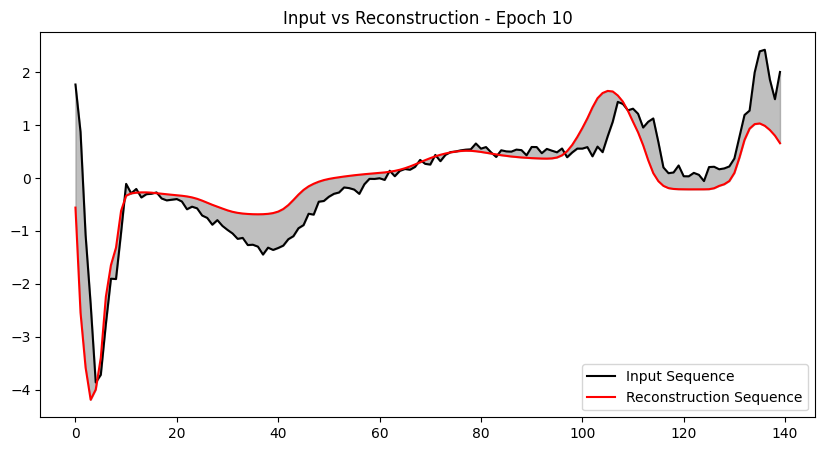

Epoch 11: Train Loss 40.4545, Val Loss 40.3198, Train Acc 35.06%, Val Acc 34.39%
No improvement. Patience 7/10
Epoch 12: Train Loss 40.2567, Val Loss 41.1276, Train Acc 35.16%, Val Acc 34.02%
No improvement. Patience 8/10
Epoch 13: Train Loss 37.4727, Val Loss 36.1366, Train Acc 36.95%, Val Acc 37.14%
Saving best model.
Epoch 14: Train Loss 34.5346, Val Loss 32.6922, Train Acc 38.74%, Val Acc 38.50%
Saving best model.
Epoch 15: Train Loss 32.7835, Val Loss 28.8209, Train Acc 40.20%, Val Acc 43.86%
Saving best model.


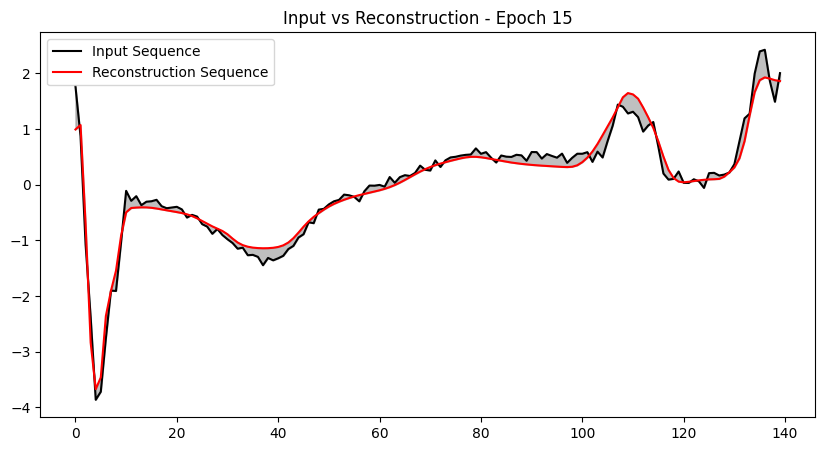

Epoch 16: Train Loss 27.7293, Val Loss 25.9126, Train Acc 46.20%, Val Acc 46.78%
Saving best model.
Epoch 17: Train Loss 24.7708, Val Loss 24.4626, Train Acc 49.71%, Val Acc 47.41%
Saving best model.
Epoch 18: Train Loss 23.8355, Val Loss 23.0116, Train Acc 51.05%, Val Acc 51.91%
Saving best model.
Epoch 19: Train Loss 22.6108, Val Loss 21.6529, Train Acc 52.61%, Val Acc 51.35%
Saving best model.
Epoch 20: Train Loss 24.5171, Val Loss 26.4396, Train Acc 51.13%, Val Acc 48.77%
No improvement. Patience 1/10


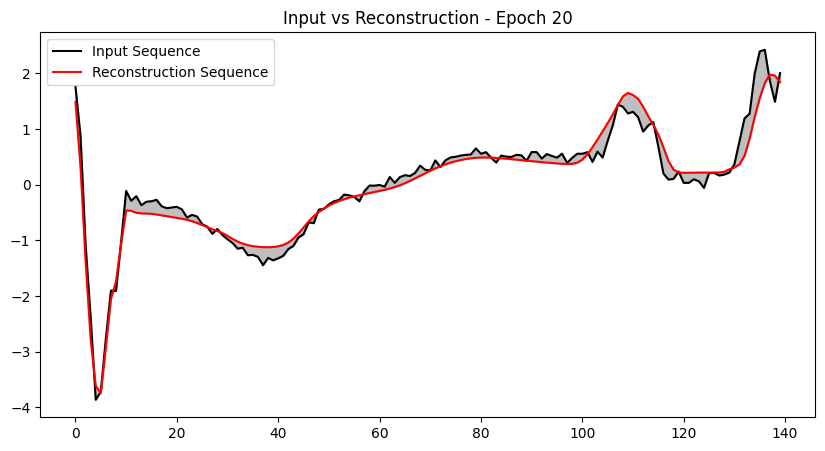

Epoch 21: Train Loss 24.0499, Val Loss 22.7212, Train Acc 51.57%, Val Acc 51.52%
No improvement. Patience 2/10
Epoch 22: Train Loss 22.2587, Val Loss 21.1435, Train Acc 53.77%, Val Acc 53.62%
Saving best model.
Epoch 23: Train Loss 25.0415, Val Loss 24.5382, Train Acc 48.48%, Val Acc 48.04%
No improvement. Patience 1/10
Epoch 24: Train Loss 22.0753, Val Loss 20.3822, Train Acc 52.53%, Val Acc 53.59%
Saving best model.
Epoch 25: Train Loss 22.2522, Val Loss 22.4526, Train Acc 52.64%, Val Acc 51.32%
No improvement. Patience 1/10


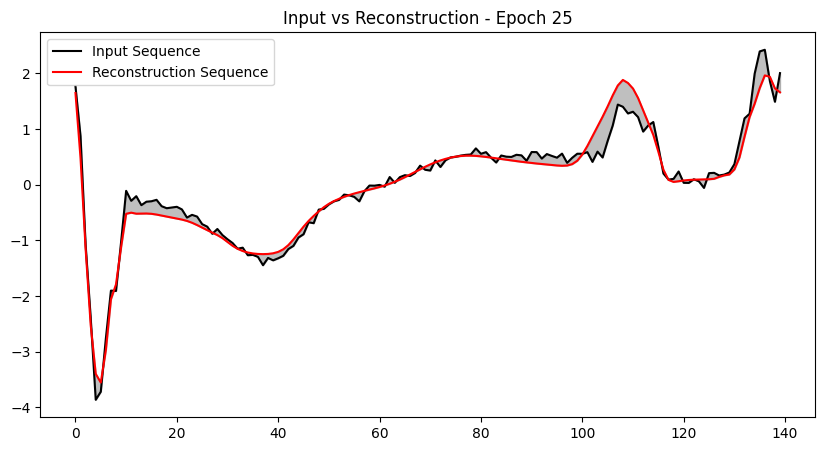

Epoch 26: Train Loss 21.3475, Val Loss 20.9225, Train Acc 54.28%, Val Acc 53.97%
No improvement. Patience 2/10
Epoch 27: Train Loss 20.5218, Val Loss 19.5259, Train Acc 55.69%, Val Acc 56.48%
Saving best model.
Epoch 28: Train Loss 20.1883, Val Loss 20.4063, Train Acc 55.88%, Val Acc 50.41%
No improvement. Patience 1/10
Epoch 29: Train Loss 26.0677, Val Loss 26.7767, Train Acc 48.54%, Val Acc 45.08%
No improvement. Patience 2/10
Epoch 30: Train Loss 25.1920, Val Loss 23.1292, Train Acc 47.90%, Val Acc 50.02%
No improvement. Patience 3/10


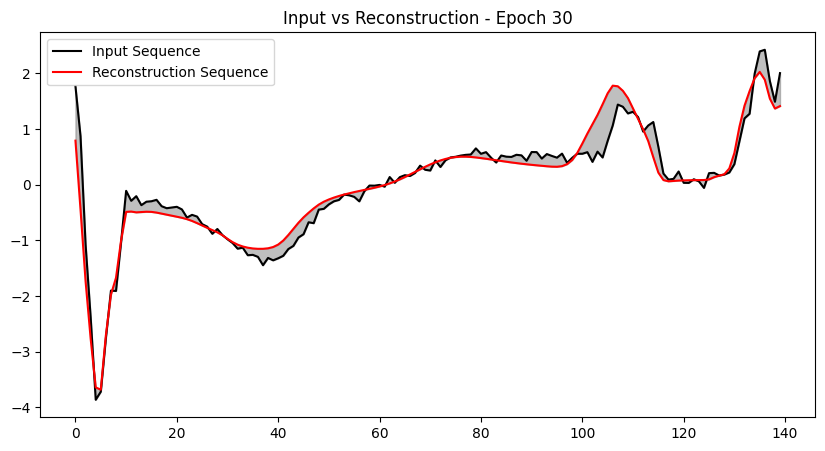

Epoch 31: Train Loss 23.7092, Val Loss 23.3659, Train Acc 50.42%, Val Acc 48.61%
No improvement. Patience 4/10
Epoch 32: Train Loss 21.9401, Val Loss 22.2867, Train Acc 53.36%, Val Acc 48.85%
No improvement. Patience 5/10
Epoch 33: Train Loss 24.5477, Val Loss 35.4451, Train Acc 49.96%, Val Acc 37.62%
No improvement. Patience 6/10
Epoch 34: Train Loss 25.0311, Val Loss 20.7305, Train Acc 48.09%, Val Acc 53.80%
No improvement. Patience 7/10
Epoch 35: Train Loss 18.9839, Val Loss 18.9558, Train Acc 57.68%, Val Acc 56.17%
Saving best model.


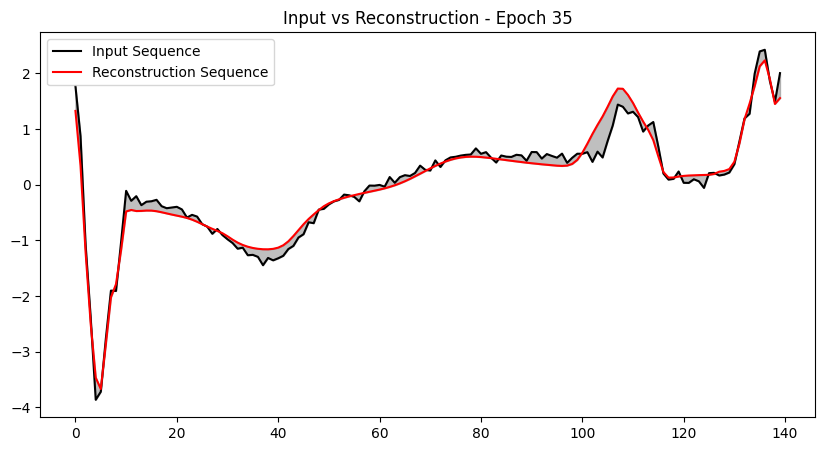

Epoch 36: Train Loss 18.2543, Val Loss 18.8251, Train Acc 59.06%, Val Acc 56.04%
Saving best model.
Epoch 37: Train Loss 17.9202, Val Loss 17.3998, Train Acc 59.76%, Val Acc 59.54%
Saving best model.
Epoch 38: Train Loss 17.5497, Val Loss 18.0349, Train Acc 60.71%, Val Acc 58.43%
No improvement. Patience 1/10
Epoch 39: Train Loss 17.1506, Val Loss 17.0976, Train Acc 61.59%, Val Acc 59.68%
Saving best model.
Epoch 40: Train Loss 16.4510, Val Loss 16.8316, Train Acc 62.91%, Val Acc 60.83%
Saving best model.


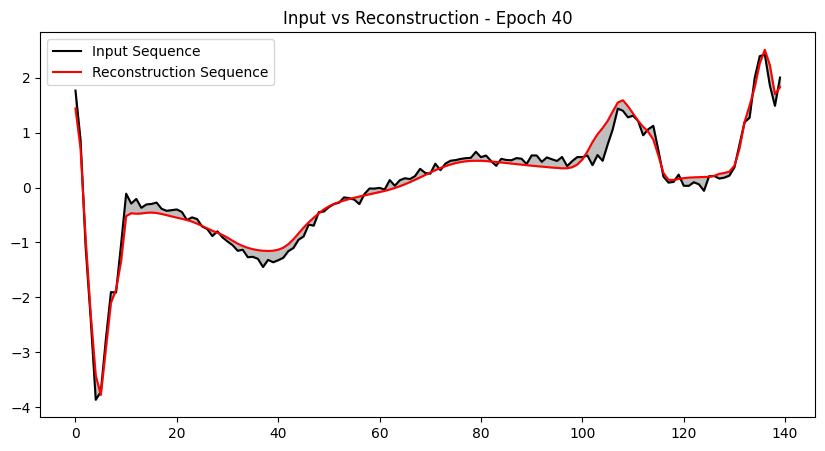

Epoch 41: Train Loss 16.0919, Val Loss 16.2274, Train Acc 62.93%, Val Acc 60.96%
Saving best model.
Epoch 42: Train Loss 15.6756, Val Loss 16.1741, Train Acc 63.30%, Val Acc 61.35%
Saving best model.
Epoch 43: Train Loss 15.1946, Val Loss 15.0372, Train Acc 64.08%, Val Acc 64.40%
Saving best model.
Epoch 44: Train Loss 14.6602, Val Loss 14.8463, Train Acc 65.31%, Val Acc 64.12%
Saving best model.
Epoch 45: Train Loss 14.5021, Val Loss 14.0529, Train Acc 65.79%, Val Acc 66.14%
Saving best model.


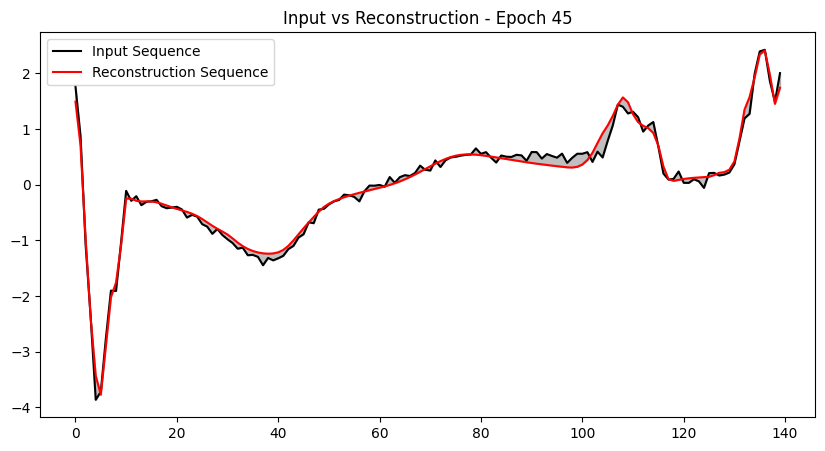

Epoch 46: Train Loss 13.9705, Val Loss 13.7129, Train Acc 66.81%, Val Acc 66.85%
Saving best model.
Epoch 47: Train Loss 13.6773, Val Loss 16.4821, Train Acc 67.55%, Val Acc 60.78%
No improvement. Patience 1/10
Epoch 48: Train Loss 13.5118, Val Loss 13.5813, Train Acc 67.88%, Val Acc 67.98%
Saving best model.
Epoch 49: Train Loss 13.4581, Val Loss 14.0926, Train Acc 68.02%, Val Acc 66.66%
No improvement. Patience 1/10
Epoch 50: Train Loss 13.2237, Val Loss 13.4395, Train Acc 68.61%, Val Acc 67.35%
Saving best model.


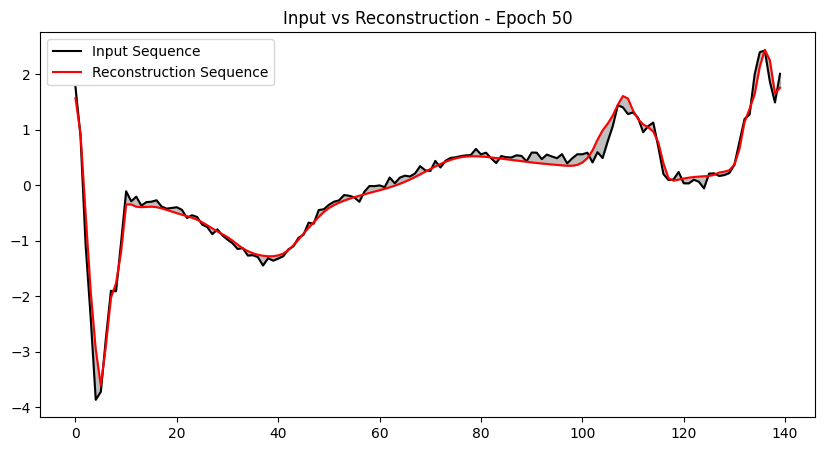

Epoch 51: Train Loss 13.2368, Val Loss 13.8963, Train Acc 68.59%, Val Acc 66.41%
No improvement. Patience 1/10
Epoch 52: Train Loss 13.0013, Val Loss 13.1707, Train Acc 69.28%, Val Acc 68.30%
Saving best model.
Epoch 53: Train Loss 12.6464, Val Loss 13.6371, Train Acc 70.24%, Val Acc 67.03%
No improvement. Patience 1/10
Epoch 54: Train Loss 12.6860, Val Loss 13.0712, Train Acc 70.25%, Val Acc 69.00%
Saving best model.
Epoch 55: Train Loss 12.4665, Val Loss 12.4873, Train Acc 70.90%, Val Acc 71.04%
Saving best model.


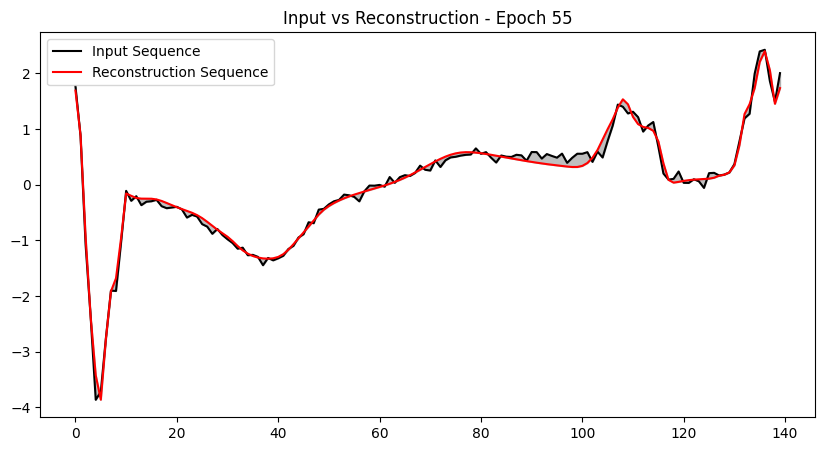

Epoch 56: Train Loss 12.0885, Val Loss 12.0132, Train Acc 72.07%, Val Acc 72.49%
Saving best model.
Epoch 57: Train Loss 11.9544, Val Loss 14.2610, Train Acc 72.79%, Val Acc 68.42%
No improvement. Patience 1/10
Epoch 58: Train Loss 12.8033, Val Loss 12.1819, Train Acc 71.24%, Val Acc 71.58%
No improvement. Patience 2/10
Epoch 59: Train Loss 11.5725, Val Loss 12.2963, Train Acc 74.11%, Val Acc 71.77%
No improvement. Patience 3/10
Epoch 60: Train Loss 11.4406, Val Loss 11.7567, Train Acc 74.47%, Val Acc 72.95%
Saving best model.


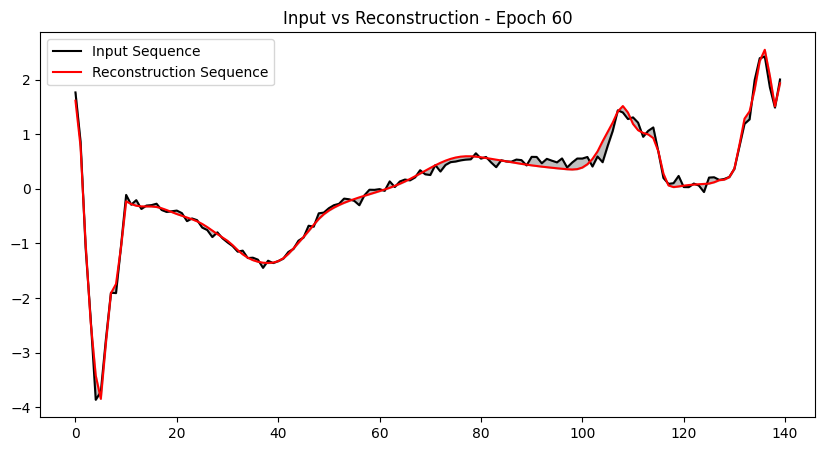

Epoch 61: Train Loss 11.4119, Val Loss 11.6700, Train Acc 74.38%, Val Acc 73.53%
Saving best model.
Epoch 62: Train Loss 11.3168, Val Loss 11.7553, Train Acc 74.65%, Val Acc 72.87%
No improvement. Patience 1/10
Epoch 63: Train Loss 11.2641, Val Loss 11.5296, Train Acc 74.88%, Val Acc 74.11%
Saving best model.
Epoch 64: Train Loss 11.1027, Val Loss 11.1523, Train Acc 75.25%, Val Acc 75.50%
Saving best model.
Epoch 65: Train Loss 10.8735, Val Loss 11.3743, Train Acc 75.95%, Val Acc 74.47%
No improvement. Patience 1/10


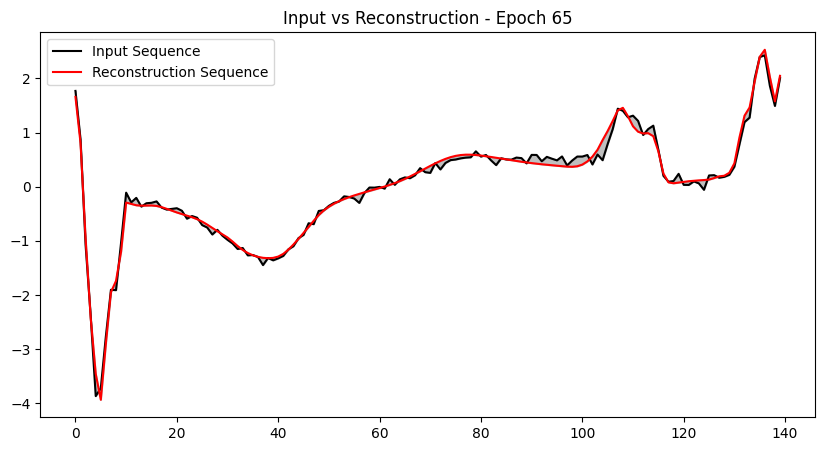

Epoch 66: Train Loss 10.8905, Val Loss 11.3919, Train Acc 75.98%, Val Acc 74.96%
No improvement. Patience 2/10
Epoch 67: Train Loss 10.8422, Val Loss 11.2248, Train Acc 76.19%, Val Acc 75.37%
No improvement. Patience 3/10
Epoch 68: Train Loss 10.7064, Val Loss 10.9773, Train Acc 76.44%, Val Acc 76.09%
Saving best model.
Epoch 69: Train Loss 10.7839, Val Loss 10.7465, Train Acc 76.42%, Val Acc 76.66%
Saving best model.
Epoch 70: Train Loss 10.7115, Val Loss 11.5393, Train Acc 76.48%, Val Acc 74.64%
No improvement. Patience 1/10


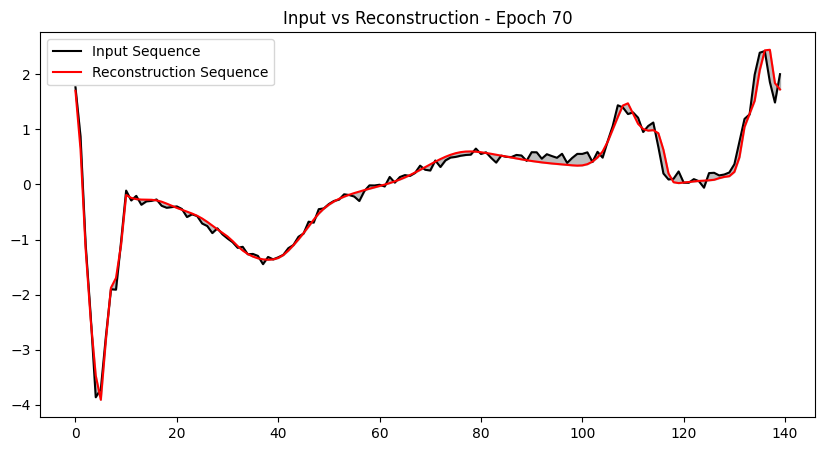

Epoch 71: Train Loss 10.5926, Val Loss 10.9010, Train Acc 76.79%, Val Acc 76.39%
No improvement. Patience 2/10
Epoch 72: Train Loss 10.5731, Val Loss 13.1289, Train Acc 77.01%, Val Acc 73.33%
No improvement. Patience 3/10
Epoch 73: Train Loss 10.4697, Val Loss 11.2949, Train Acc 77.17%, Val Acc 74.71%
No improvement. Patience 4/10
Epoch 74: Train Loss 10.5044, Val Loss 10.6668, Train Acc 77.14%, Val Acc 77.21%
Saving best model.
Epoch 75: Train Loss 10.6589, Val Loss 11.1319, Train Acc 76.79%, Val Acc 76.25%
No improvement. Patience 1/10


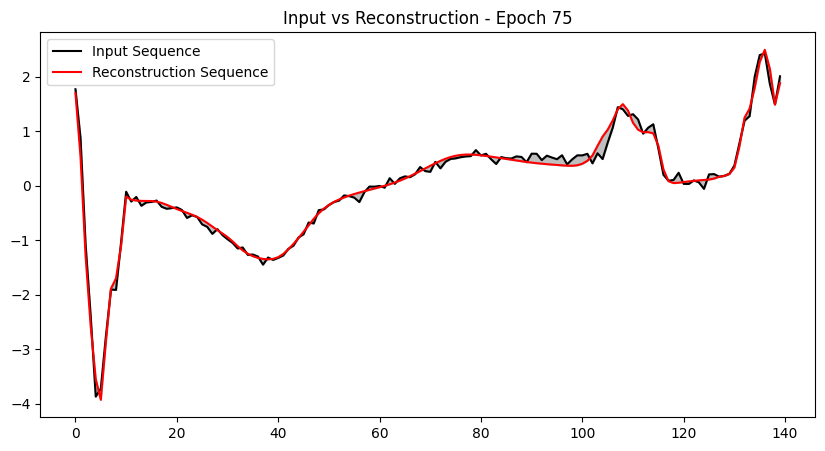

Epoch 76: Train Loss 10.4381, Val Loss 10.8130, Train Acc 77.38%, Val Acc 76.75%
No improvement. Patience 2/10
Epoch 77: Train Loss 10.4528, Val Loss 10.9053, Train Acc 77.31%, Val Acc 76.35%
No improvement. Patience 3/10
Epoch 78: Train Loss 10.3266, Val Loss 10.7552, Train Acc 77.75%, Val Acc 76.96%
No improvement. Patience 4/10
Epoch 79: Train Loss 10.2739, Val Loss 12.2579, Train Acc 77.79%, Val Acc 73.48%
No improvement. Patience 5/10
Epoch 80: Train Loss 10.2670, Val Loss 10.3645, Train Acc 77.89%, Val Acc 77.91%
Saving best model.


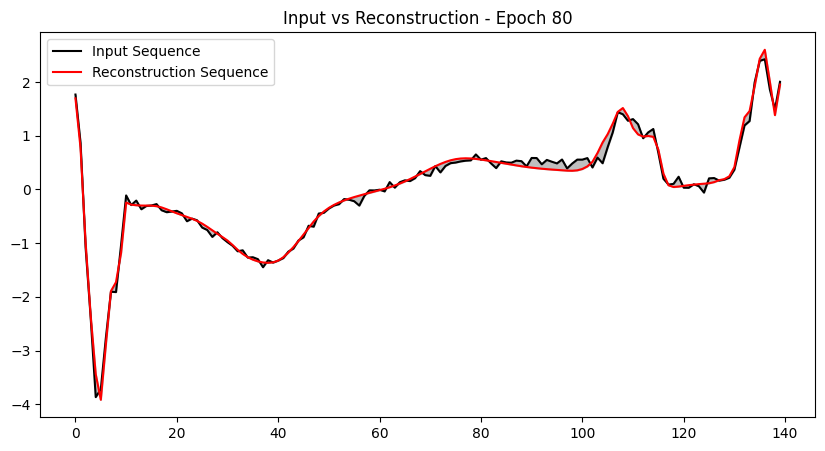

Epoch 81: Train Loss 10.1794, Val Loss 11.1015, Train Acc 78.11%, Val Acc 75.42%
No improvement. Patience 1/10
Epoch 82: Train Loss 10.1407, Val Loss 12.0495, Train Acc 78.22%, Val Acc 73.64%
No improvement. Patience 2/10
Epoch 83: Train Loss 10.0990, Val Loss 10.9434, Train Acc 78.43%, Val Acc 75.79%
No improvement. Patience 3/10
Epoch 84: Train Loss 10.1759, Val Loss 10.5735, Train Acc 78.22%, Val Acc 77.11%
No improvement. Patience 4/10
Epoch 85: Train Loss 10.0787, Val Loss 10.3352, Train Acc 78.56%, Val Acc 78.18%
Saving best model.


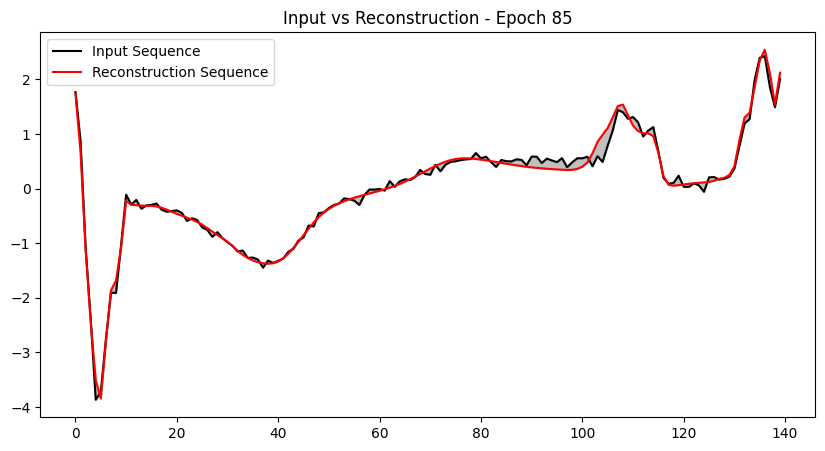

Epoch 86: Train Loss 10.0248, Val Loss 10.2873, Train Acc 78.74%, Val Acc 78.60%
Saving best model.
Epoch 87: Train Loss 10.0171, Val Loss 10.3610, Train Acc 78.67%, Val Acc 78.23%
No improvement. Patience 1/10
Epoch 88: Train Loss 10.0009, Val Loss 10.6072, Train Acc 78.83%, Val Acc 77.38%
No improvement. Patience 2/10
Epoch 89: Train Loss 9.9684, Val Loss 10.6644, Train Acc 78.96%, Val Acc 77.29%
No improvement. Patience 3/10
Epoch 90: Train Loss 9.9478, Val Loss 10.4071, Train Acc 79.02%, Val Acc 77.58%
No improvement. Patience 4/10


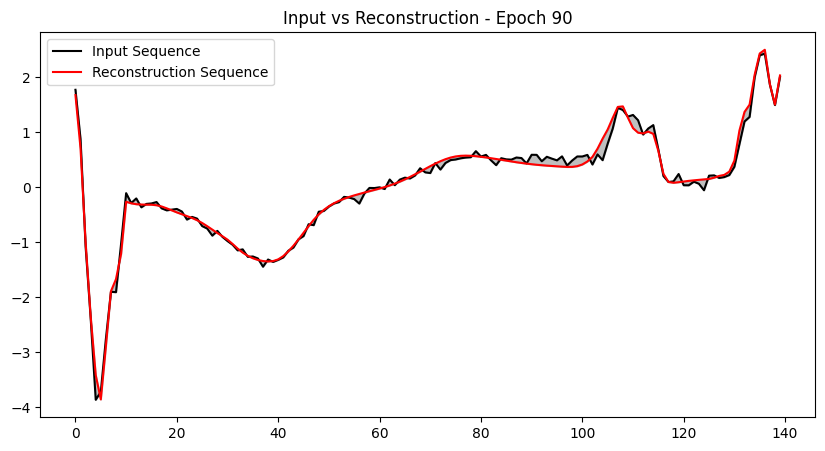

Epoch 91: Train Loss 9.9480, Val Loss 10.1396, Train Acc 78.94%, Val Acc 79.19%
Saving best model.
Epoch 92: Train Loss 9.7987, Val Loss 10.2968, Train Acc 79.31%, Val Acc 78.41%
No improvement. Patience 1/10
Epoch 93: Train Loss 9.9107, Val Loss 10.3856, Train Acc 79.03%, Val Acc 78.35%
No improvement. Patience 2/10
Epoch 94: Train Loss 10.1565, Val Loss 11.4980, Train Acc 78.57%, Val Acc 75.79%
No improvement. Patience 3/10
Epoch 95: Train Loss 9.8368, Val Loss 10.2755, Train Acc 79.23%, Val Acc 78.56%
No improvement. Patience 4/10


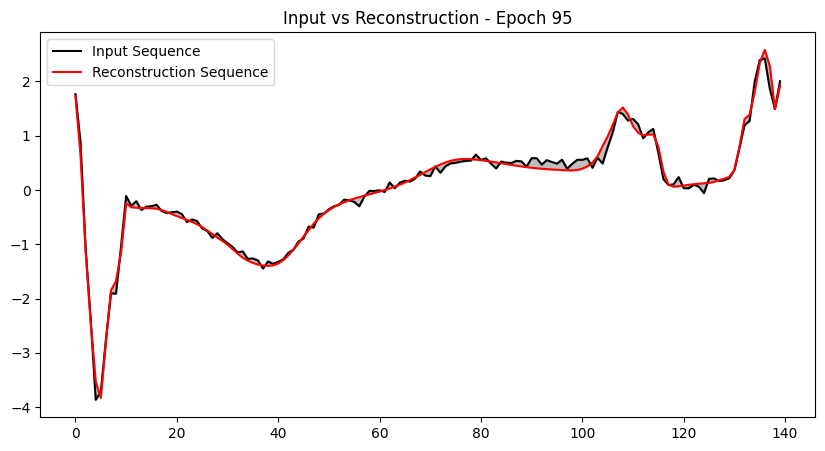

Epoch 96: Train Loss 9.7137, Val Loss 10.4653, Train Acc 79.59%, Val Acc 77.95%
No improvement. Patience 5/10
Epoch 97: Train Loss 9.7379, Val Loss 10.1855, Train Acc 79.57%, Val Acc 78.61%
No improvement. Patience 6/10
Epoch 98: Train Loss 8.9888, Val Loss 10.5732, Train Acc 82.06%, Val Acc 77.43%
No improvement. Patience 7/10
Epoch 99: Train Loss 8.9127, Val Loss 9.8181, Train Acc 82.33%, Val Acc 80.24%
Saving best model.
Epoch 100: Train Loss 8.8676, Val Loss 9.9403, Train Acc 82.50%, Val Acc 79.81%
No improvement. Patience 1/10


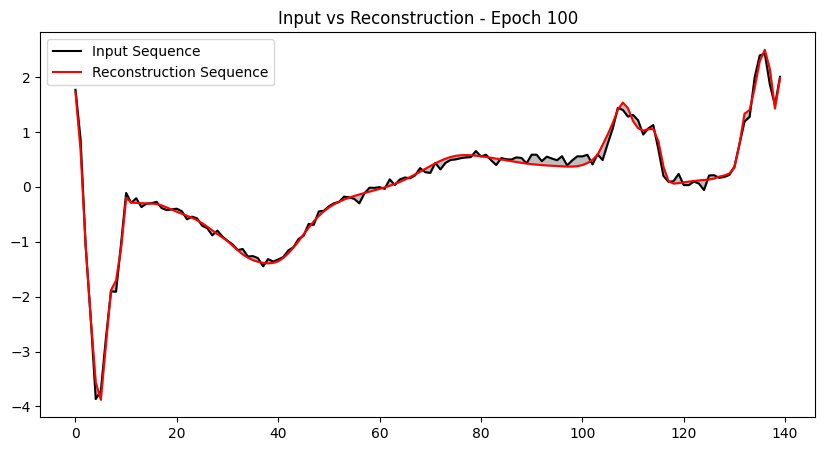

In [32]:
save_path = '/kaggle/working/lstm_auto_encoder.pth'
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=100,
    save_path=save_path,
    patience=10,
    tolerance=0.1
)



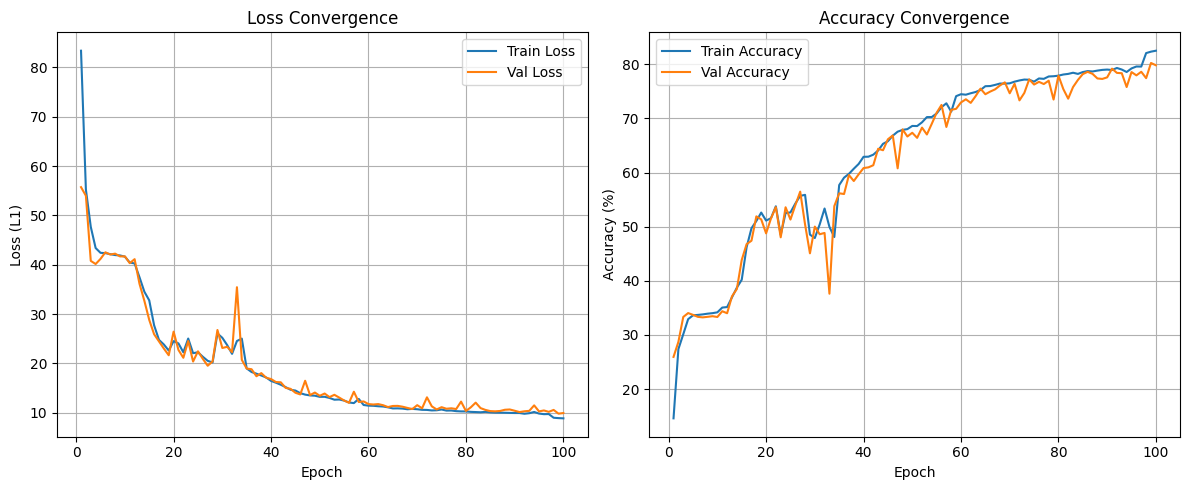

In [33]:
# Plot convergence
plot_convergence(history, save_path='convergence_plot_lstm_auto_encoder.png')


In [15]:
model_lstm2 = Autoencoder(seq_len, n_features, 128)
model_lstm2.to(device)
model_lstm2, history_lstm2 = train_model_v2(
    model_lstm2,
    train_dataset,
    val_dataset,
    n_epochs=100,
    save_path='lstm_v2.pth'
)

Epoch 1: Train Loss 0.3880, Val Loss 0.3221, Train Acc 43.41%, Val Acc 49.30%
Saving best model.
Epoch 2: Train Loss 0.2777, Val Loss 0.1635, Train Acc 50.87%, Val Acc 61.37%
Saving best model.
Epoch 3: Train Loss 0.1798, Val Loss 0.1480, Train Acc 59.52%, Val Acc 62.14%
Saving best model.
Epoch 4: Train Loss 0.1472, Val Loss 0.1162, Train Acc 64.54%, Val Acc 68.70%
Saving best model.
Epoch 5: Train Loss 0.1094, Val Loss 0.0865, Train Acc 70.55%, Val Acc 74.03%
Saving best model.
Epoch 6: Train Loss 0.0928, Val Loss 0.0899, Train Acc 74.25%, Val Acc 74.97%
No improvement. Patience 1/10
Epoch 7: Train Loss 0.0842, Val Loss 0.0775, Train Acc 76.15%, Val Acc 76.49%
Saving best model.
Epoch 8: Train Loss 0.0780, Val Loss 0.0765, Train Acc 77.78%, Val Acc 76.44%
Saving best model.
Epoch 9: Train Loss 0.0738, Val Loss 0.0703, Train Acc 79.01%, Val Acc 77.94%
Saving best model.
Epoch 10: Train Loss 0.0710, Val Loss 0.0676, Train Acc 79.77%, Val Acc 79.40%
Saving best model.
Epoch 11: Train Lo

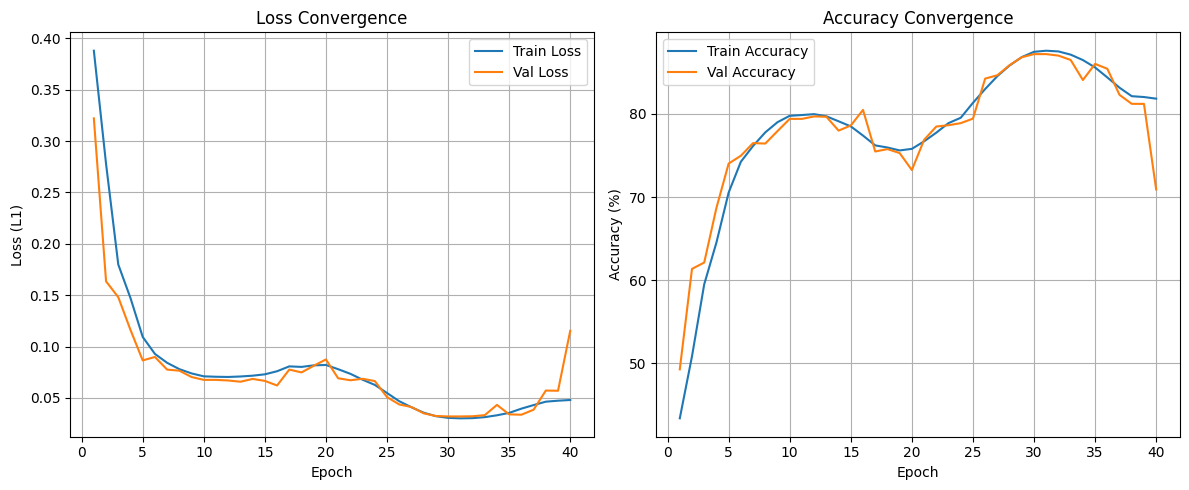

In [16]:
# Plot convergence
plot_convergence(history_lstm2, save_path='convergence_plot_lstm_auto_encoder2.png')


### validation

In [34]:

# Run validation
model.load_state_dict(torch.load('/kaggle/working/lstm_auto_encoder.pth'))  # Load best model
reconstruction_errors = validate_model(model, test_normal_dataset, tolerance=0.1, device='cuda')

Validation Loss: 9.3420, Validation Accuracy: 80.93%
Mean Reconstruction Error: 0.0667
Std Reconstruction Error: 0.0793


In [17]:

# Run validation
model_lstm2.load_state_dict(torch.load('/kaggle/working/lstm_v2.pth'))  # Load best model
reconstruction_errors2 = validate_model(model_lstm2, test_normal_dataset, tolerance=0.1, device='cuda')

/tmp/ipykernel_31/1591181729.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lstm2.load_state_dict(torch.load('/kaggle/working/lstm_v2.pth'))  # Load best model


Validation Loss: 15.0456, Validation Accuracy: 64.46%
Mean Reconstruction Error: 0.1075
Std Reconstruction Error: 0.1409


### test on abnormal ecg

In [35]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report



# Set the threshold
threshold = 0.2197
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Run anomaly detection
lstm_normal_errors, lstm_normal_preds = get_reconstruction_errors(model, test_normal_dataset, threshold, device='cuda')
lstm_anomaly_errors, lstm_anomaly_preds = get_reconstruction_errors(model, test_anomaly_dataset, threshold, device='cuda')

# Combine for full evaluation
all_preds = np.concatenate([lstm_normal_preds, lstm_anomaly_preds])
true_labels = np.concatenate([
    np.zeros(len(lstm_normal_preds)),
    np.ones(len(lstm_anomaly_preds))   
])

# Evaluate
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, all_preds, average='binary')
print(f"\n📊 Evaluation on Mixed Test Set:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Full classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, all_preds, target_names=["Normal", "Anomaly"], digits=4))


Anomaly Detection Threshold: 0.2197

📊 Evaluation on Mixed Test Set:
Precision: 0.9965
Recall:    0.5792
F1-Score:  0.7325

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.1274    0.9677    0.2252     18480
     Anomaly     0.9965    0.5792    0.7325    291060

    accuracy                         0.6024    309540
   macro avg     0.5619    0.7734    0.4788    309540
weighted avg     0.9446    0.6024    0.7023    309540



In [18]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report



# Set the threshold
threshold = 0.2197
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Run anomaly detection
lstm_normal_errors, lstm_normal_preds = get_reconstruction_errors(model_lstm2, test_normal_dataset, threshold, device='cuda')
lstm_anomaly_errors, lstm_anomaly_preds = get_reconstruction_errors(model_lstm2, test_anomaly_dataset, threshold, device='cuda')

# Combine for full evaluation
all_preds = np.concatenate([lstm_normal_preds, lstm_anomaly_preds])
true_labels = np.concatenate([
    np.zeros(len(lstm_normal_preds)),
    np.ones(len(lstm_anomaly_preds))   
])

# Evaluate
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, all_preds, average='binary')
print(f"\n📊 Evaluation on Mixed Test Set:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Full classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, all_preds, target_names=["Normal", "Anomaly"], digits=4))


Anomaly Detection Threshold: 0.2197

📊 Evaluation on Mixed Test Set:
Precision: 0.9884
Recall:    0.5797
F1-Score:  0.7307

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.1188    0.8926    0.2097     18480
     Anomaly     0.9884    0.5797    0.7307    291060

    accuracy                         0.5983    309540
   macro avg     0.5536    0.7361    0.4702    309540
weighted avg     0.9365    0.5983    0.6996    309540



## model 2 : gru auto encoder

### model architecture

In [36]:
class GRUEncoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(GRUEncoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.gru1 = nn.GRU(input_size=n_features, hidden_size=self.hidden_dim, batch_first=True)
        self.gru2 = nn.GRU(input_size=self.hidden_dim, hidden_size=embedding_dim, batch_first=True)

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, _ = self.gru1(x)
        x, hidden_n = self.gru2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))


In [37]:
class GRUDecoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(GRUDecoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.gru1 = nn.GRU(input_size=input_dim, hidden_size=input_dim, batch_first=True)
        self.gru2 = nn.GRU(input_size=input_dim, hidden_size=self.hidden_dim, batch_first=True)

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)


In [38]:
class GRUAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(GRUAutoencoder, self).__init__()
        self.encoder = GRUEncoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = GRUDecoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### training

Epoch 1: Train Loss 60.3980, Val Loss 53.1680, Train Acc 21.68%, Val Acc 26.17%
Saving best model.


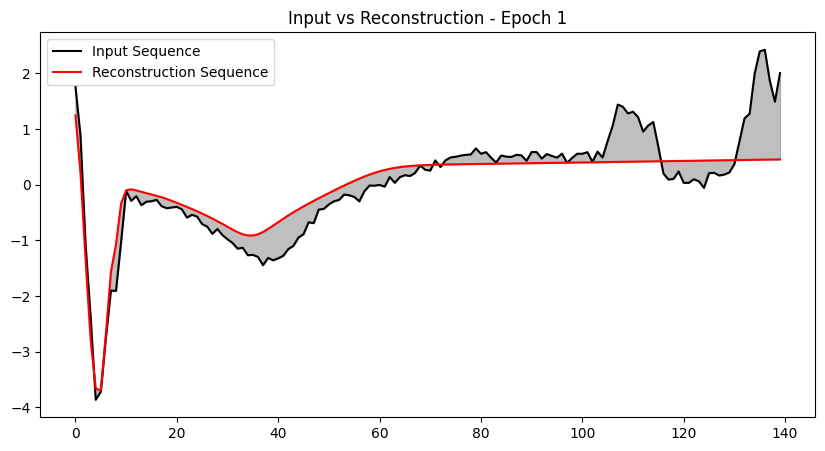

Epoch 2: Train Loss 53.0275, Val Loss 47.7228, Train Acc 25.63%, Val Acc 31.18%
Saving best model.
Epoch 3: Train Loss 48.6795, Val Loss 46.2959, Train Acc 28.73%, Val Acc 31.81%
Saving best model.
Epoch 4: Train Loss 45.8065, Val Loss 46.4488, Train Acc 31.27%, Val Acc 33.00%
No improvement. Patience 1/10
Epoch 5: Train Loss 43.7147, Val Loss 41.5551, Train Acc 32.61%, Val Acc 37.43%
Saving best model.


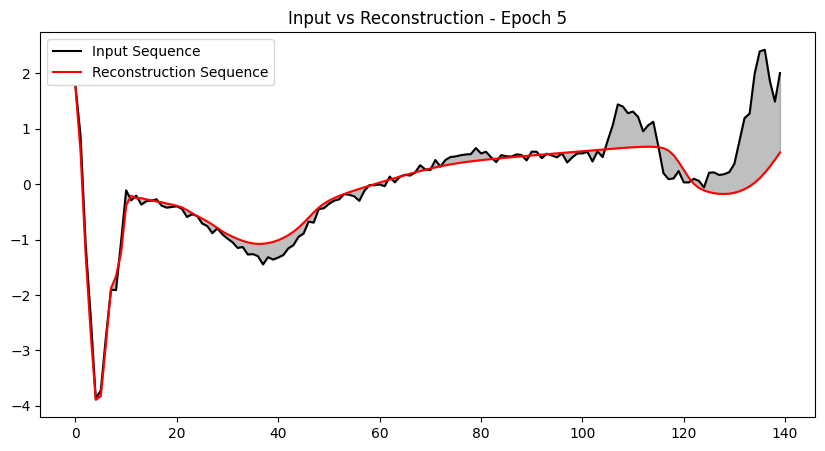

Epoch 6: Train Loss 44.7168, Val Loss 45.4974, Train Acc 32.86%, Val Acc 34.49%
No improvement. Patience 1/10
Epoch 7: Train Loss 43.8607, Val Loss 43.4555, Train Acc 33.21%, Val Acc 36.48%
No improvement. Patience 2/10
Epoch 8: Train Loss 43.2510, Val Loss 43.9821, Train Acc 34.07%, Val Acc 36.01%
No improvement. Patience 3/10
Epoch 9: Train Loss 43.1351, Val Loss 44.5953, Train Acc 34.00%, Val Acc 33.01%
No improvement. Patience 4/10
Epoch 10: Train Loss 42.5907, Val Loss 34.9534, Train Acc 34.84%, Val Acc 38.93%
Saving best model.


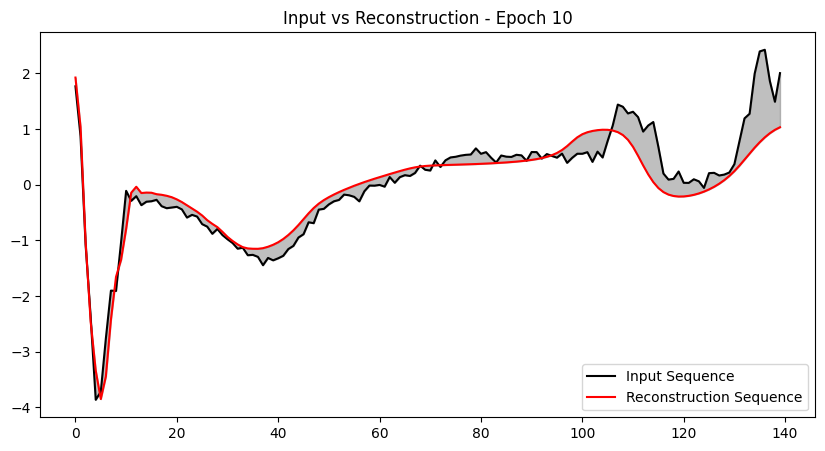

Epoch 11: Train Loss 42.2478, Val Loss 39.5035, Train Acc 35.57%, Val Acc 39.35%
No improvement. Patience 1/10
Epoch 12: Train Loss 40.3637, Val Loss 36.6983, Train Acc 35.53%, Val Acc 39.28%
No improvement. Patience 2/10
Epoch 13: Train Loss 41.9802, Val Loss 35.4000, Train Acc 35.51%, Val Acc 39.04%
No improvement. Patience 3/10
Epoch 14: Train Loss 41.2038, Val Loss 34.7878, Train Acc 35.84%, Val Acc 37.56%
Saving best model.
Epoch 15: Train Loss 40.7081, Val Loss 44.5908, Train Acc 35.72%, Val Acc 31.17%
No improvement. Patience 1/10


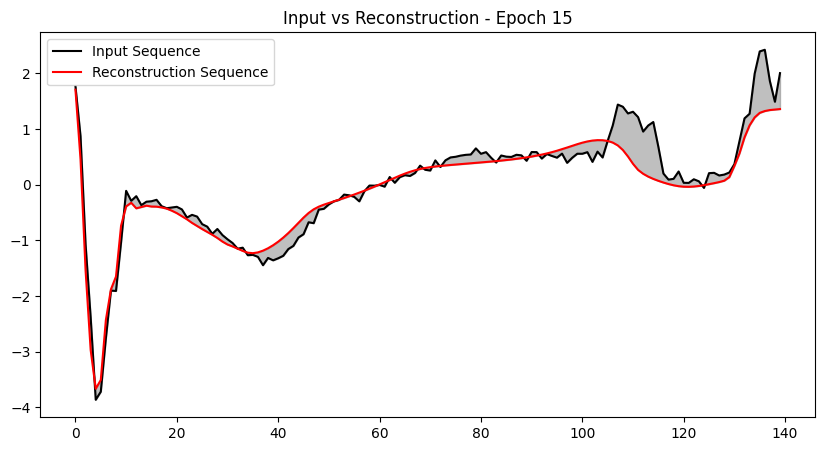

Epoch 16: Train Loss 38.4268, Val Loss 32.9892, Train Acc 36.97%, Val Acc 36.34%
Saving best model.
Epoch 17: Train Loss 35.3142, Val Loss 28.6730, Train Acc 37.66%, Val Acc 43.11%
Saving best model.
Epoch 18: Train Loss 33.1420, Val Loss 26.2580, Train Acc 41.05%, Val Acc 48.50%
Saving best model.
Epoch 19: Train Loss 31.2421, Val Loss 34.7428, Train Acc 42.60%, Val Acc 40.87%
No improvement. Patience 1/10
Epoch 20: Train Loss 31.4601, Val Loss 31.4334, Train Acc 42.64%, Val Acc 45.92%
No improvement. Patience 2/10


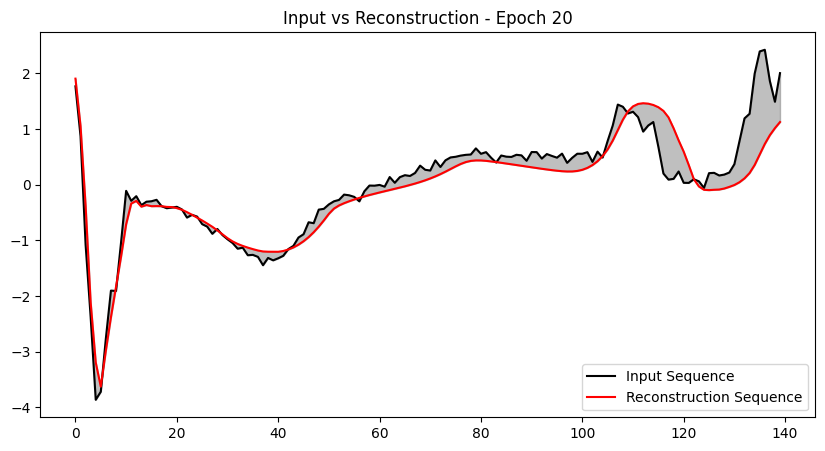

Epoch 21: Train Loss 30.4412, Val Loss 27.3316, Train Acc 43.43%, Val Acc 44.77%
No improvement. Patience 3/10
Epoch 22: Train Loss 30.0903, Val Loss 28.3181, Train Acc 43.39%, Val Acc 45.09%
No improvement. Patience 4/10
Epoch 23: Train Loss 29.4307, Val Loss 28.1215, Train Acc 44.44%, Val Acc 46.33%
No improvement. Patience 5/10
Epoch 24: Train Loss 29.7780, Val Loss 23.7084, Train Acc 43.97%, Val Acc 49.97%
Saving best model.
Epoch 25: Train Loss 46.6254, Val Loss 44.2640, Train Acc 31.26%, Val Acc 31.29%
No improvement. Patience 1/10


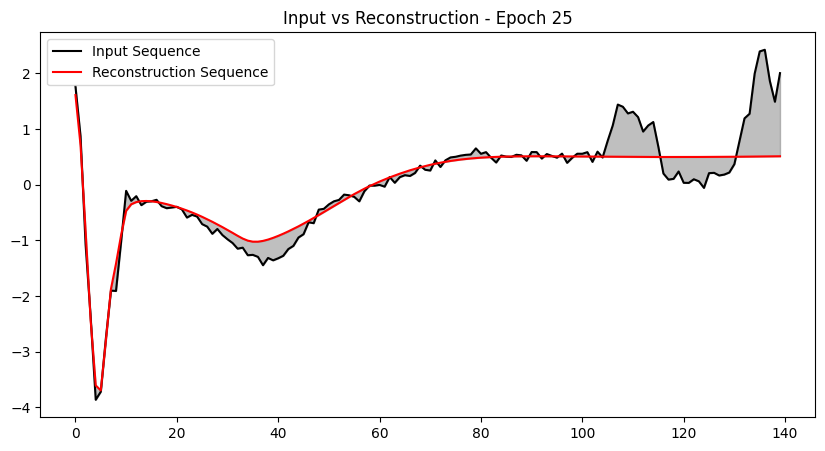

Epoch 26: Train Loss 44.1595, Val Loss 42.4504, Train Acc 33.58%, Val Acc 37.82%
No improvement. Patience 2/10
Epoch 27: Train Loss 43.4458, Val Loss 42.9552, Train Acc 34.87%, Val Acc 35.11%
No improvement. Patience 3/10
Epoch 28: Train Loss 42.4422, Val Loss 42.7730, Train Acc 35.58%, Val Acc 36.26%
No improvement. Patience 4/10
Epoch 29: Train Loss 41.8174, Val Loss 42.3138, Train Acc 36.50%, Val Acc 30.35%
No improvement. Patience 5/10
Epoch 30: Train Loss 41.7081, Val Loss 46.8695, Train Acc 36.73%, Val Acc 32.27%
No improvement. Patience 6/10


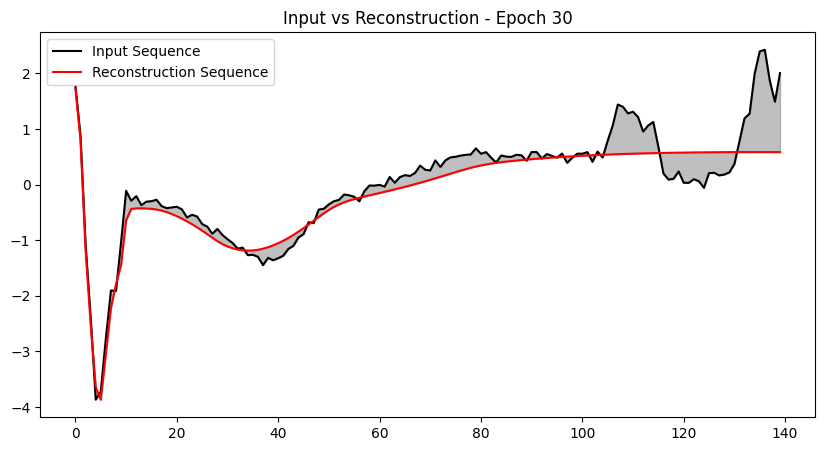

Epoch 31: Train Loss 33.2799, Val Loss 23.8990, Train Acc 43.11%, Val Acc 50.34%
No improvement. Patience 7/10
Epoch 32: Train Loss 26.2892, Val Loss 22.4707, Train Acc 49.62%, Val Acc 53.31%
Saving best model.
Epoch 33: Train Loss 24.9284, Val Loss 21.0537, Train Acc 51.52%, Val Acc 55.46%
Saving best model.
Epoch 34: Train Loss 23.6259, Val Loss 20.9274, Train Acc 52.92%, Val Acc 54.91%
Saving best model.
Epoch 35: Train Loss 23.2280, Val Loss 22.1027, Train Acc 53.57%, Val Acc 55.09%
No improvement. Patience 1/10


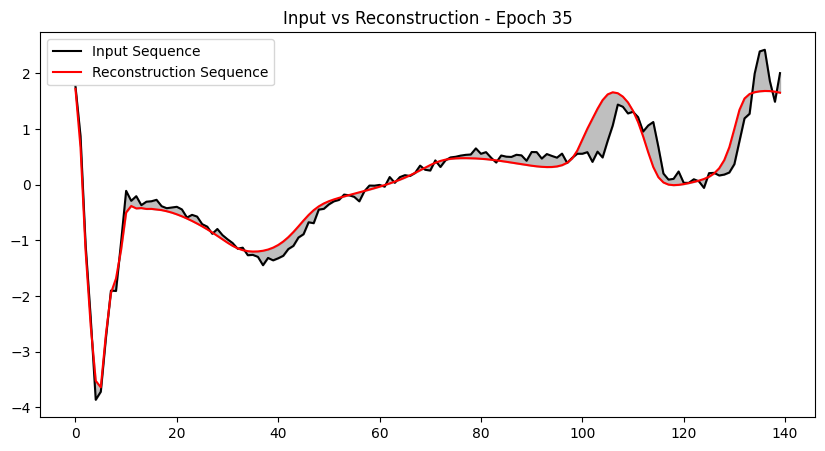

Epoch 36: Train Loss 22.6335, Val Loss 24.1107, Train Acc 54.75%, Val Acc 53.75%
No improvement. Patience 2/10
Epoch 37: Train Loss 22.2956, Val Loss 19.8950, Train Acc 55.29%, Val Acc 57.54%
Saving best model.
Epoch 38: Train Loss 21.8196, Val Loss 18.3808, Train Acc 55.97%, Val Acc 60.16%
Saving best model.
Epoch 39: Train Loss 21.5402, Val Loss 19.0484, Train Acc 56.66%, Val Acc 57.99%
No improvement. Patience 1/10
Epoch 40: Train Loss 21.1698, Val Loss 18.5987, Train Acc 57.10%, Val Acc 60.27%
No improvement. Patience 2/10


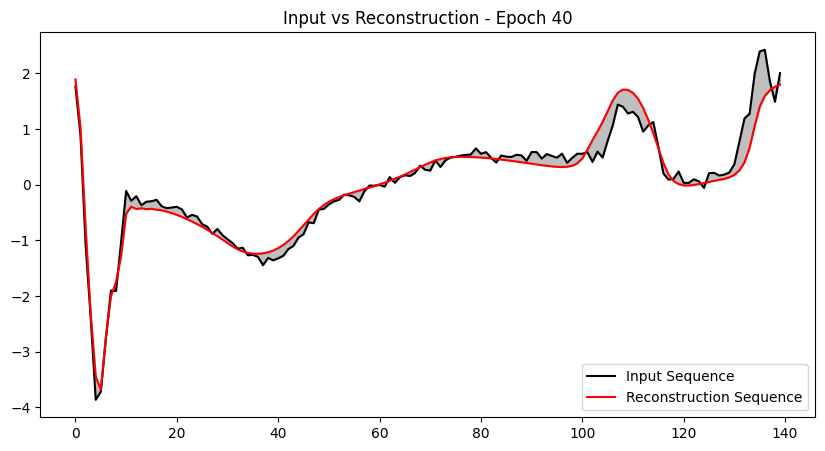

Epoch 41: Train Loss 21.0228, Val Loss 25.2253, Train Acc 57.44%, Val Acc 56.65%
No improvement. Patience 3/10
Epoch 42: Train Loss 21.1794, Val Loss 17.8878, Train Acc 57.76%, Val Acc 60.10%
Saving best model.
Epoch 43: Train Loss 20.7369, Val Loss 18.0619, Train Acc 58.34%, Val Acc 61.46%
No improvement. Patience 1/10
Epoch 44: Train Loss 20.1781, Val Loss 18.9735, Train Acc 59.02%, Val Acc 60.51%
No improvement. Patience 2/10
Epoch 45: Train Loss 19.7543, Val Loss 16.8980, Train Acc 59.48%, Val Acc 63.41%
Saving best model.


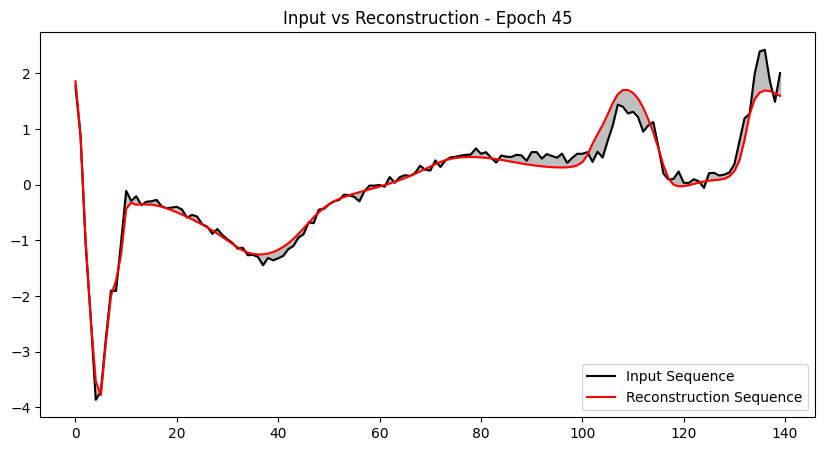

Epoch 46: Train Loss 19.7783, Val Loss 17.1868, Train Acc 60.06%, Val Acc 64.08%
No improvement. Patience 1/10
Epoch 47: Train Loss 19.5773, Val Loss 17.4598, Train Acc 60.21%, Val Acc 62.92%
No improvement. Patience 2/10
Epoch 48: Train Loss 19.6050, Val Loss 16.5619, Train Acc 60.25%, Val Acc 64.00%
Saving best model.
Epoch 49: Train Loss 19.1677, Val Loss 16.4415, Train Acc 60.86%, Val Acc 63.99%
Saving best model.
Epoch 50: Train Loss 19.1529, Val Loss 16.8681, Train Acc 61.08%, Val Acc 61.48%
No improvement. Patience 1/10


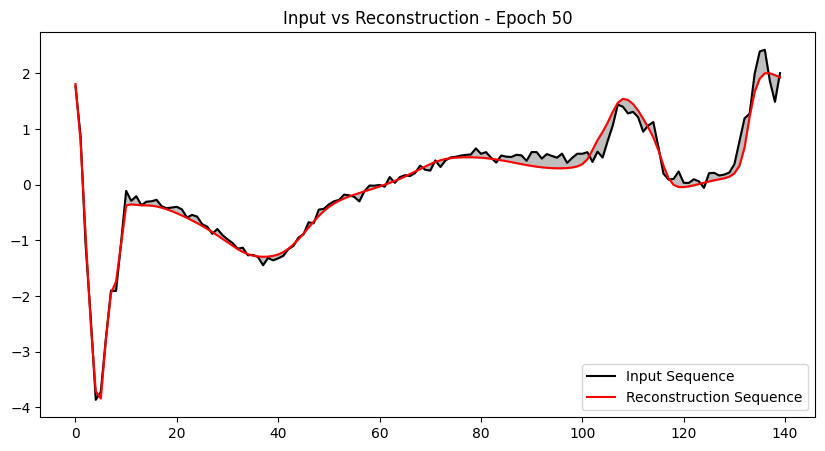

Epoch 51: Train Loss 18.9968, Val Loss 16.1299, Train Acc 61.11%, Val Acc 65.54%
Saving best model.
Epoch 52: Train Loss 18.9705, Val Loss 16.6905, Train Acc 61.20%, Val Acc 63.64%
No improvement. Patience 1/10
Epoch 53: Train Loss 18.8093, Val Loss 18.3655, Train Acc 61.53%, Val Acc 60.70%
No improvement. Patience 2/10
Epoch 54: Train Loss 18.5200, Val Loss 16.8870, Train Acc 62.13%, Val Acc 62.60%
No improvement. Patience 3/10
Epoch 55: Train Loss 18.7283, Val Loss 17.0239, Train Acc 61.83%, Val Acc 61.81%
No improvement. Patience 4/10


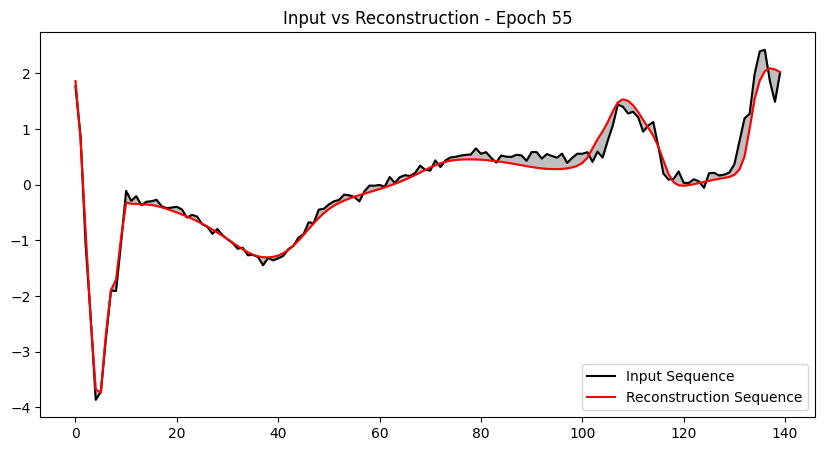

Epoch 56: Train Loss 18.6323, Val Loss 16.8450, Train Acc 62.20%, Val Acc 62.54%
No improvement. Patience 5/10
Epoch 57: Train Loss 18.2106, Val Loss 18.3319, Train Acc 62.66%, Val Acc 61.51%
No improvement. Patience 6/10
Epoch 58: Train Loss 15.8165, Val Loss 18.6089, Train Acc 67.30%, Val Acc 64.88%
No improvement. Patience 7/10
Epoch 59: Train Loss 15.6847, Val Loss 18.7932, Train Acc 67.68%, Val Acc 64.52%
No improvement. Patience 8/10
Epoch 60: Train Loss 15.6441, Val Loss 15.2784, Train Acc 67.89%, Val Acc 66.79%
Saving best model.


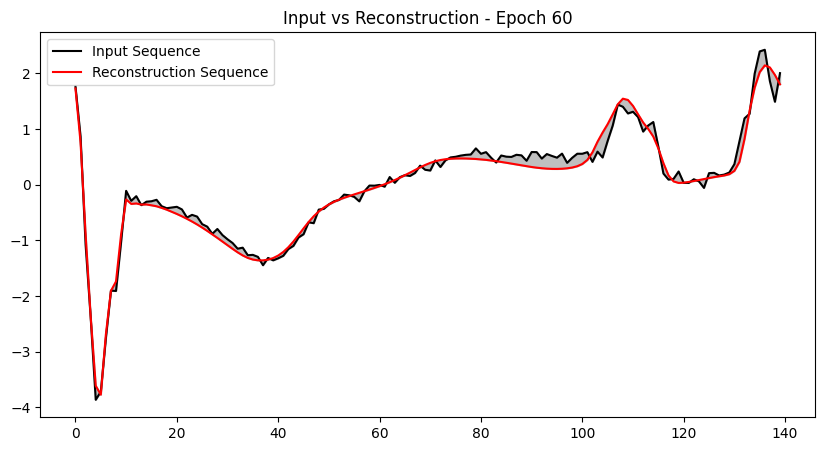

Epoch 61: Train Loss 15.5405, Val Loss 16.3641, Train Acc 68.00%, Val Acc 66.75%
No improvement. Patience 1/10
Epoch 62: Train Loss 15.2996, Val Loss 16.2005, Train Acc 68.39%, Val Acc 67.50%
No improvement. Patience 2/10
Epoch 63: Train Loss 15.1352, Val Loss 14.2585, Train Acc 68.64%, Val Acc 69.35%
Saving best model.
Epoch 64: Train Loss 15.2008, Val Loss 16.5398, Train Acc 68.77%, Val Acc 67.15%
No improvement. Patience 1/10
Epoch 65: Train Loss 14.9270, Val Loss 18.5619, Train Acc 69.09%, Val Acc 65.65%
No improvement. Patience 2/10


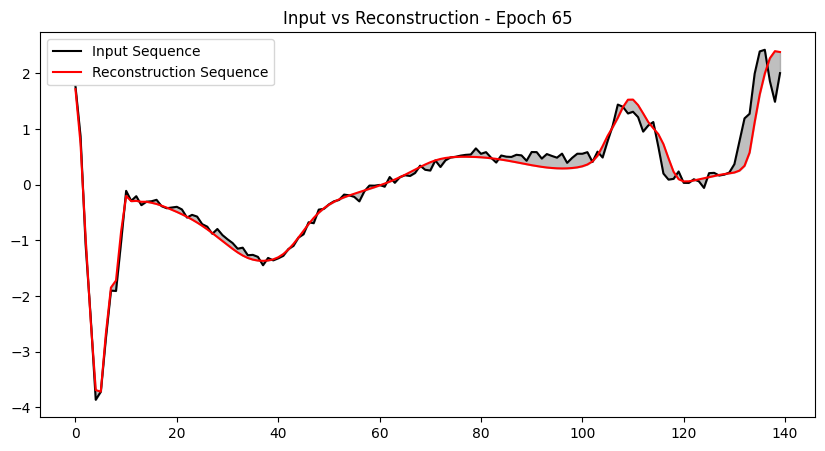

Epoch 66: Train Loss 14.9306, Val Loss 14.9816, Train Acc 69.28%, Val Acc 68.60%
No improvement. Patience 3/10
Epoch 67: Train Loss 14.7209, Val Loss 15.6068, Train Acc 69.56%, Val Acc 68.46%
No improvement. Patience 4/10
Epoch 68: Train Loss 14.5033, Val Loss 15.3804, Train Acc 69.74%, Val Acc 67.88%
No improvement. Patience 5/10
Epoch 69: Train Loss 14.6128, Val Loss 18.0248, Train Acc 69.81%, Val Acc 65.34%
No improvement. Patience 6/10
Epoch 70: Train Loss 13.2422, Val Loss 13.3385, Train Acc 72.69%, Val Acc 71.83%
Saving best model.


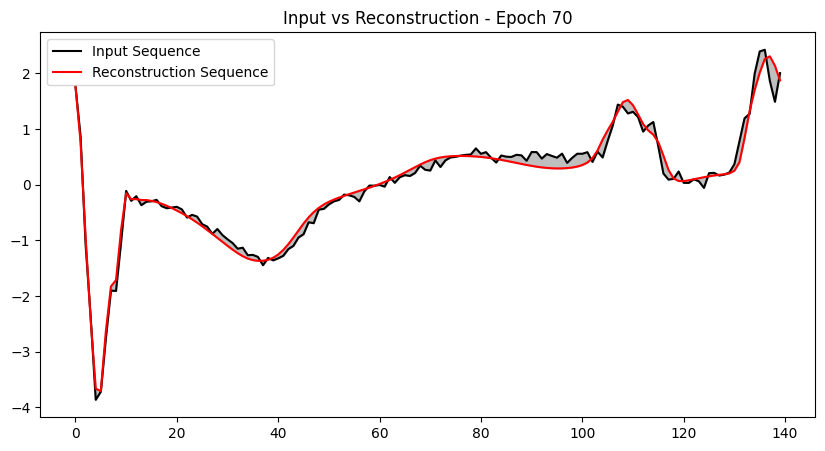

Epoch 71: Train Loss 13.0908, Val Loss 13.2215, Train Acc 72.97%, Val Acc 72.07%
Saving best model.
Epoch 72: Train Loss 13.0327, Val Loss 13.7367, Train Acc 73.16%, Val Acc 71.85%
No improvement. Patience 1/10
Epoch 73: Train Loss 12.8690, Val Loss 13.9743, Train Acc 73.45%, Val Acc 71.32%
No improvement. Patience 2/10
Epoch 74: Train Loss 12.7820, Val Loss 13.2750, Train Acc 73.64%, Val Acc 72.16%
No improvement. Patience 3/10
Epoch 75: Train Loss 12.7060, Val Loss 13.1802, Train Acc 73.79%, Val Acc 72.72%
Saving best model.


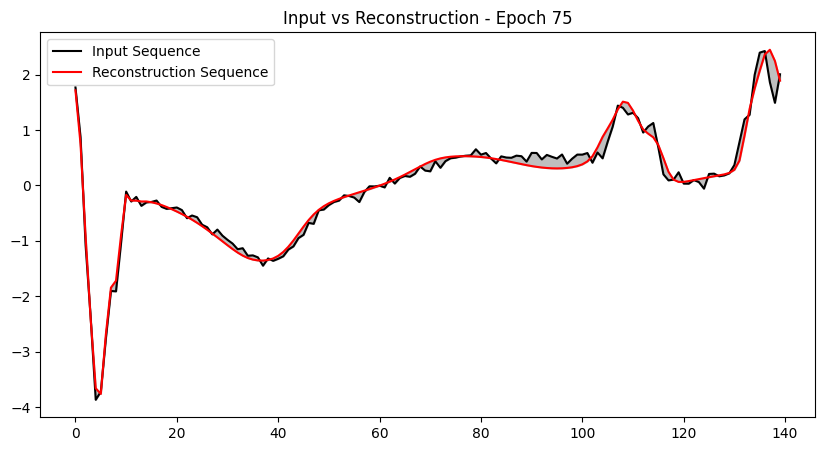

Epoch 76: Train Loss 12.5746, Val Loss 13.9660, Train Acc 74.08%, Val Acc 71.80%
No improvement. Patience 1/10
Epoch 77: Train Loss 12.6306, Val Loss 12.8521, Train Acc 74.00%, Val Acc 73.03%
Saving best model.
Epoch 78: Train Loss 12.4188, Val Loss 12.8979, Train Acc 74.35%, Val Acc 72.68%
No improvement. Patience 1/10
Epoch 79: Train Loss 12.4218, Val Loss 12.3793, Train Acc 74.31%, Val Acc 73.78%
Saving best model.
Epoch 80: Train Loss 12.3110, Val Loss 12.3645, Train Acc 74.38%, Val Acc 73.37%
Saving best model.


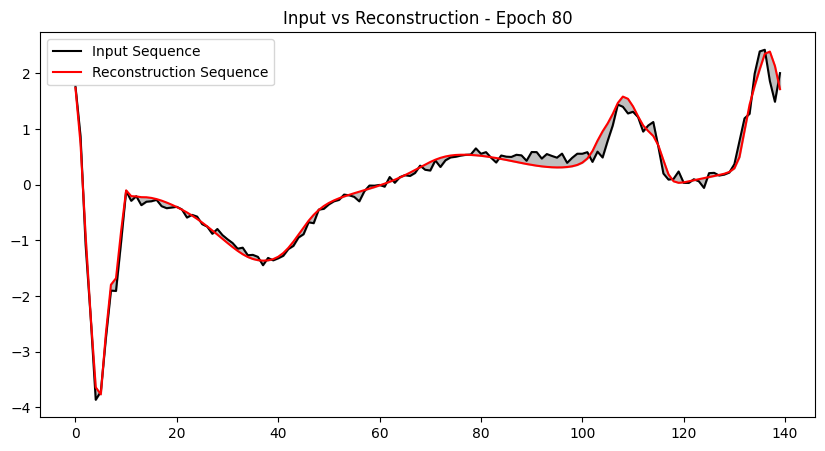

Epoch 81: Train Loss 12.0179, Val Loss 14.4393, Train Acc 74.68%, Val Acc 71.08%
No improvement. Patience 1/10
Epoch 82: Train Loss 11.8906, Val Loss 12.4879, Train Acc 74.87%, Val Acc 72.85%
No improvement. Patience 2/10
Epoch 83: Train Loss 11.6961, Val Loss 12.3235, Train Acc 75.09%, Val Acc 72.82%
Saving best model.
Epoch 84: Train Loss 11.5702, Val Loss 11.7313, Train Acc 75.40%, Val Acc 74.30%
Saving best model.
Epoch 85: Train Loss 11.4927, Val Loss 11.9520, Train Acc 75.53%, Val Acc 73.35%
No improvement. Patience 1/10


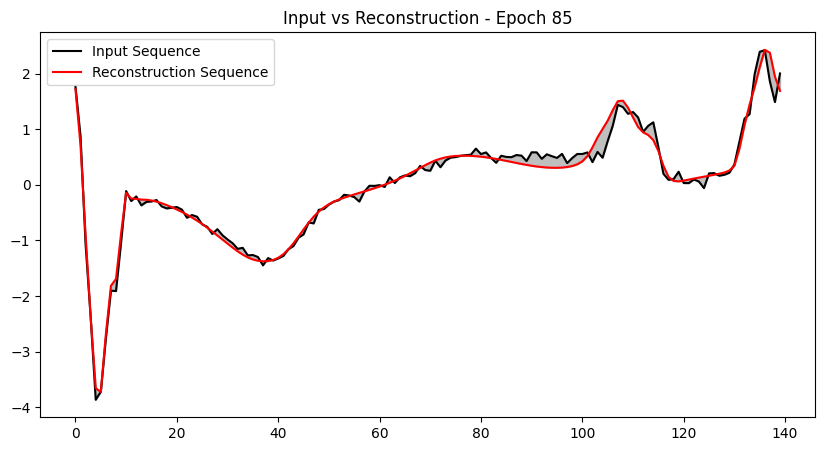

Epoch 86: Train Loss 11.4288, Val Loss 11.2563, Train Acc 75.68%, Val Acc 75.19%
Saving best model.
Epoch 87: Train Loss 11.4051, Val Loss 13.3398, Train Acc 75.78%, Val Acc 70.68%
No improvement. Patience 1/10
Epoch 88: Train Loss 11.3819, Val Loss 11.2649, Train Acc 75.86%, Val Acc 75.35%
No improvement. Patience 2/10
Epoch 89: Train Loss 11.1574, Val Loss 11.6168, Train Acc 76.21%, Val Acc 74.84%
No improvement. Patience 3/10
Epoch 90: Train Loss 11.1789, Val Loss 13.6541, Train Acc 76.21%, Val Acc 70.49%
No improvement. Patience 4/10


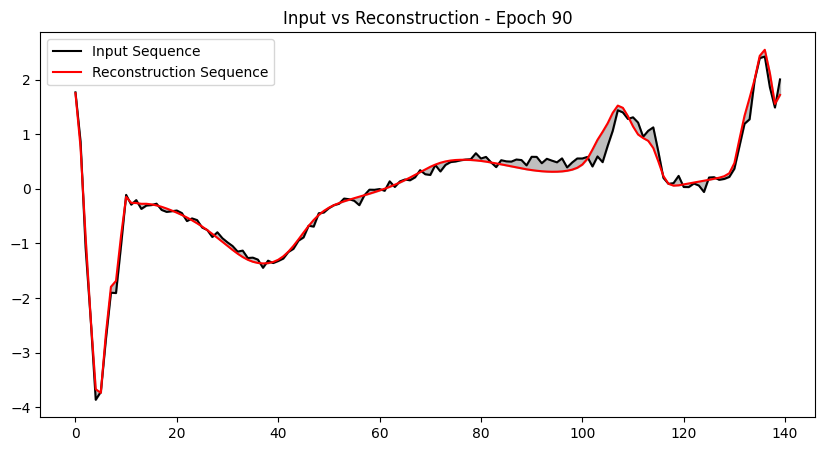

Epoch 91: Train Loss 11.1917, Val Loss 12.6455, Train Acc 76.20%, Val Acc 74.08%
No improvement. Patience 5/10
Epoch 92: Train Loss 11.0168, Val Loss 11.4979, Train Acc 76.56%, Val Acc 74.65%
No improvement. Patience 6/10
Epoch 93: Train Loss 10.3142, Val Loss 10.8508, Train Acc 78.26%, Val Acc 76.23%
Saving best model.
Epoch 94: Train Loss 10.1700, Val Loss 10.7897, Train Acc 78.57%, Val Acc 76.76%
Saving best model.
Epoch 95: Train Loss 10.1489, Val Loss 10.5883, Train Acc 78.66%, Val Acc 76.88%
Saving best model.


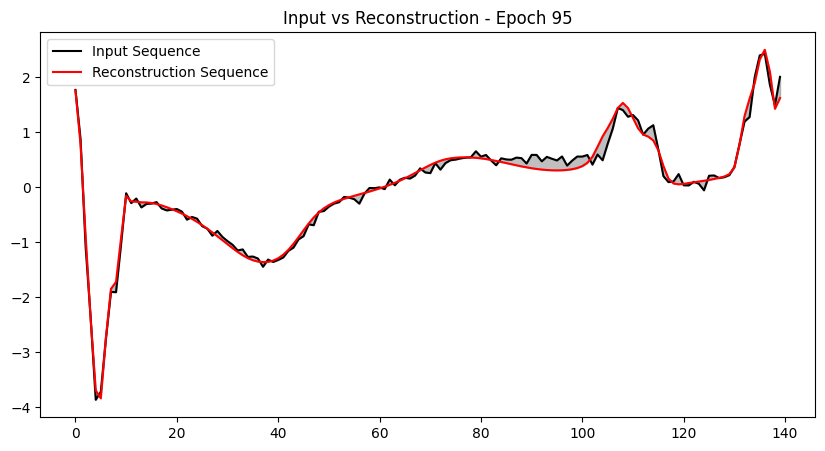

Epoch 96: Train Loss 10.0683, Val Loss 10.6902, Train Acc 78.82%, Val Acc 76.65%
No improvement. Patience 1/10
Epoch 97: Train Loss 10.0367, Val Loss 10.4670, Train Acc 78.96%, Val Acc 77.28%
Saving best model.
Epoch 98: Train Loss 9.9431, Val Loss 10.5180, Train Acc 79.18%, Val Acc 77.25%
No improvement. Patience 1/10
Epoch 99: Train Loss 9.8819, Val Loss 10.1629, Train Acc 79.38%, Val Acc 78.05%
Saving best model.
Epoch 100: Train Loss 9.7964, Val Loss 10.2275, Train Acc 79.58%, Val Acc 78.13%
No improvement. Patience 1/10


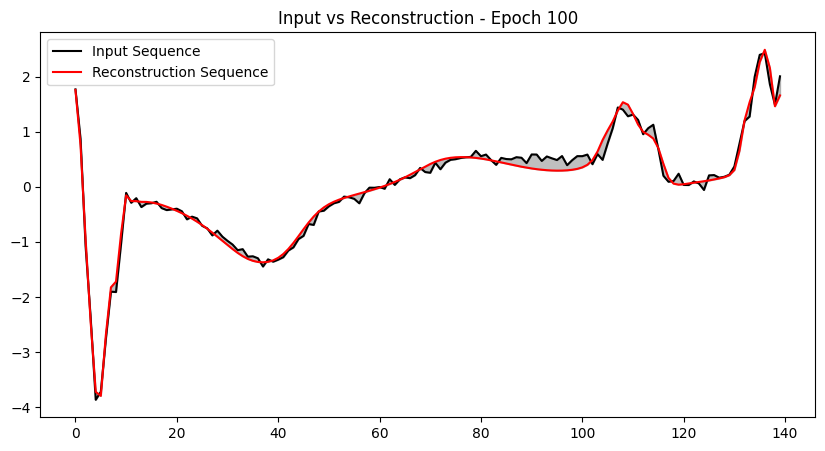

In [39]:
save_path = '/kaggle/working/gru_auto_encoder.pth'
model3GRU = GRUAutoencoder(seq_len, n_features, 128)
model3GRU = model3GRU.to(device)
model3GRU, history3 = train_model(
    model3GRU,
    train_dataset,
    val_dataset,
    n_epochs=100,
    save_path=save_path,
    patience=10,
    tolerance=0.1
)



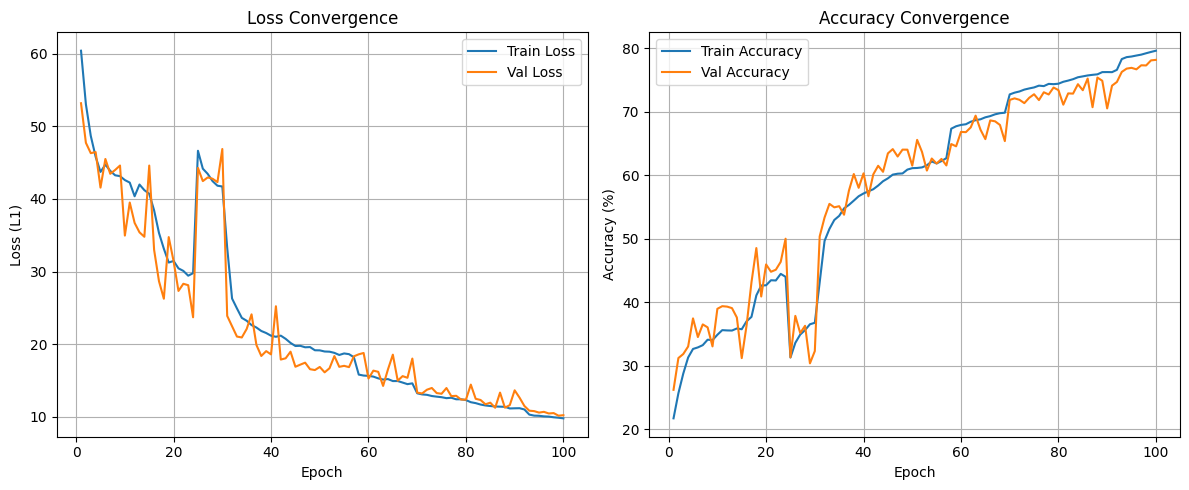

In [40]:
# Plot convergence
plot_convergence(history3, save_path='convergence_plot_gru_auto_encoder.png')


In [26]:
model_gru2 = GRUAutoencoder(seq_len, n_features, 128)
model_gru2.to(device)
model_gru2, history_gru2 = train_model_v2(
    model_gru2,
    train_dataset,
    val_dataset,
    n_epochs=100,
    save_path='gru_v2.pth'
)

Epoch 1: Train Loss 0.3555, Val Loss 0.2888, Train Acc 44.14%, Val Acc 48.69%
Saving best model.
Epoch 2: Train Loss 0.2626, Val Loss 0.2794, Train Acc 47.69%, Val Acc 46.27%
Saving best model.
Epoch 3: Train Loss 0.1843, Val Loss 0.1464, Train Acc 58.59%, Val Acc 63.44%
Saving best model.
Epoch 4: Train Loss 0.1557, Val Loss 0.1327, Train Acc 62.42%, Val Acc 66.10%
Saving best model.
Epoch 5: Train Loss 0.1281, Val Loss 0.0988, Train Acc 66.63%, Val Acc 69.45%
Saving best model.
Epoch 6: Train Loss 0.1009, Val Loss 0.0882, Train Acc 71.23%, Val Acc 70.29%
Saving best model.
Epoch 7: Train Loss 0.0851, Val Loss 0.0766, Train Acc 75.10%, Val Acc 76.72%
Saving best model.
Epoch 8: Train Loss 0.0772, Val Loss 0.0704, Train Acc 77.44%, Val Acc 78.22%
Saving best model.
Epoch 9: Train Loss 0.0729, Val Loss 0.0673, Train Acc 78.68%, Val Acc 79.27%
Saving best model.
Epoch 10: Train Loss 0.0709, Val Loss 0.0669, Train Acc 79.40%, Val Acc 79.64%
Saving best model.
Epoch 11: Train Loss 0.0705, 

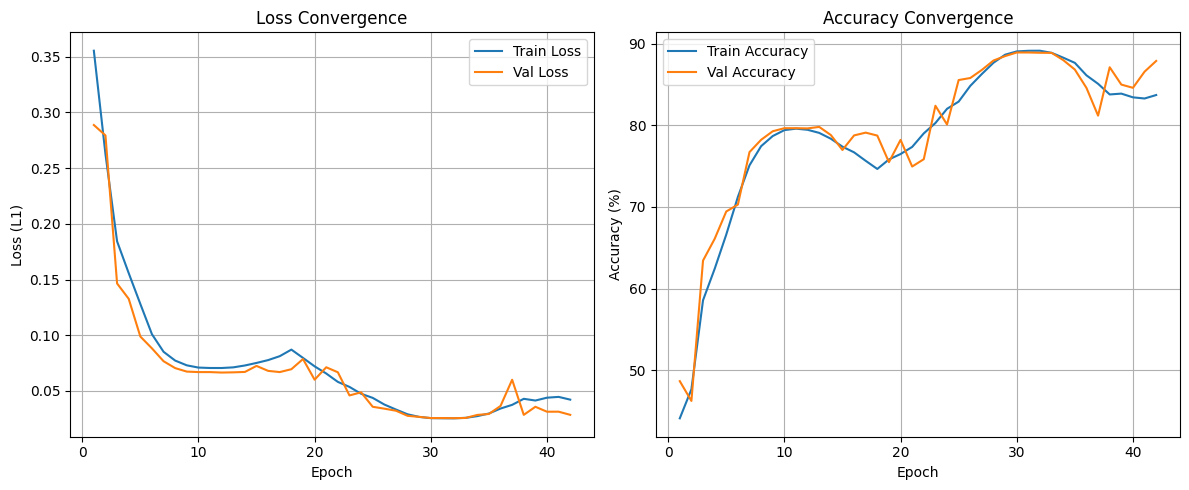

In [27]:
# Plot convergence
plot_convergence(history_gru2, save_path='convergence_plot_gru_auto_encoder2.png')


### validation

In [41]:

# Run validation
model3GRU.load_state_dict(torch.load('/kaggle/working/gru_auto_encoder.pth'))  # Load best model
reconstruction_errors = validate_model(model3GRU, test_normal_dataset, tolerance=0.1, device='cuda')

Validation Loss: 10.4513, Validation Accuracy: 77.62%
Mean Reconstruction Error: 0.0747
Std Reconstruction Error: 0.0910


In [28]:

# Run validation
model_gru2.load_state_dict(torch.load('/kaggle/working/gru_v2.pth'))  # Load best model
reconstruction_errors2 = validate_model(model_gru2, test_normal_dataset, tolerance=0.1, device='cuda')

/tmp/ipykernel_31/2715583994.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gru2.load_state_dict(torch.load('/kaggle/working/gru_v2.pth'))  # Load best model


Validation Loss: 13.7101, Validation Accuracy: 68.16%
Mean Reconstruction Error: 0.0979
Std Reconstruction Error: 0.1272


### test on abnormal ecg

In [1]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report



# Set the threshold
threshold = 0.2197
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Run anomaly detection
gru_normal_errors, gru_normal_preds = get_reconstruction_errors(model3GRU, test_normal_dataset, threshold, device='cuda')
gru_anomaly_errors, gru_anomaly_preds = get_reconstruction_errors(model3GRU, test_anomaly_dataset, threshold, device='cuda')

# Combine for full evaluation
all_preds = np.concatenate([gru_normal_preds, gru_anomaly_preds])
true_labels = np.concatenate([
    np.zeros(len(gru_normal_preds)), 
    np.ones(len(gru_anomaly_preds))  
])

# Evaluate
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, all_preds, average='binary')
print(f"\n📊 Evaluation on Mixed Test Set:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Full classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, all_preds, target_names=["Normal", "Anomaly"], digits=4))


Anomaly Detection Threshold: 0.2197


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.gru(



📊 Evaluation on Mixed Test Set:
Precision: 0.9942
Recall:    0.5318
F1-Score:  0.6929

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.1143    0.9515    0.2040     18480
     Anomaly     0.9942    0.5318    0.6929    291060

    accuracy                         0.5568    309540
   macro avg     0.5543    0.7416    0.4485    309540
weighted avg     0.9417    0.5568    0.6637    309540



In [29]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report



# Set the threshold
threshold = 0.2197
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Run anomaly detection
gru_normal_errors, gru_normal_preds = get_reconstruction_errors(model_gru2, test_normal_dataset, threshold, device='cuda')
gru_anomaly_errors, gru_anomaly_preds = get_reconstruction_errors(model_gru2, test_anomaly_dataset, threshold, device='cuda')

# Combine for full evaluation
all_preds = np.concatenate([gru_normal_preds, gru_anomaly_preds])
true_labels = np.concatenate([
    np.zeros(len(gru_normal_preds)), 
    np.ones(len(gru_anomaly_preds))  
])

# Evaluate
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, all_preds, average='binary')
print(f"\n📊 Evaluation on Mixed Test Set:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Full classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, all_preds, target_names=["Normal", "Anomaly"], digits=4))


Anomaly Detection Threshold: 0.2197

📊 Evaluation on Mixed Test Set:
Precision: 0.9907
Recall:    0.6157
F1-Score:  0.7595

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.1306    0.9091    0.2284     18480
     Anomaly     0.9907    0.6157    0.7595    291060

    accuracy                         0.6332    309540
   macro avg     0.5607    0.7624    0.4939    309540
weighted avg     0.9394    0.6332    0.7277    309540



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


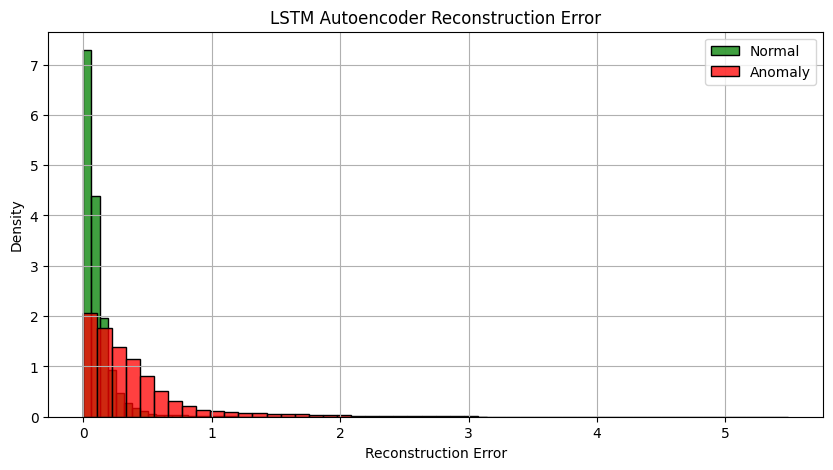

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


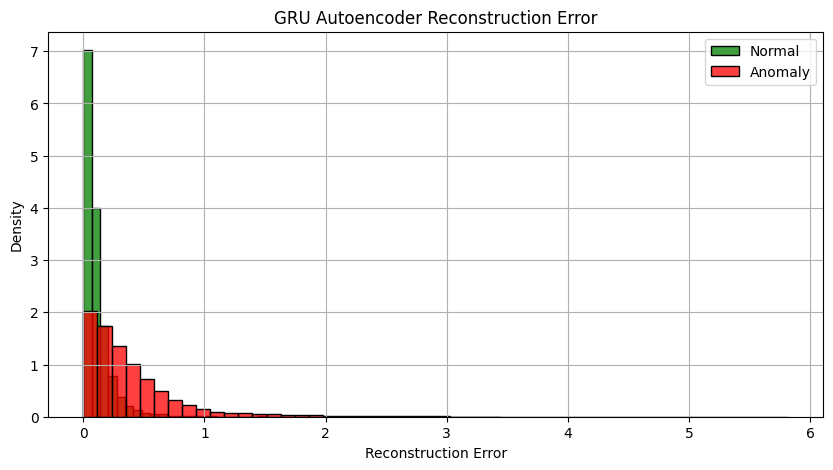

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_errors(normal_errors, anomaly_errors, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(normal_errors, bins=50, color='green', label='Normal', stat='density')
    sns.histplot(anomaly_errors, bins=50, color='red', label='Anomaly', stat='density')
    plt.title(title)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for LSTM
plot_errors(lstm_normal_errors, lstm_anomaly_errors, 'LSTM Autoencoder Reconstruction Error')

# Plot for GRU
plot_errors(gru_normal_errors, gru_anomaly_errors, 'GRU Autoencoder Reconstruction Error')

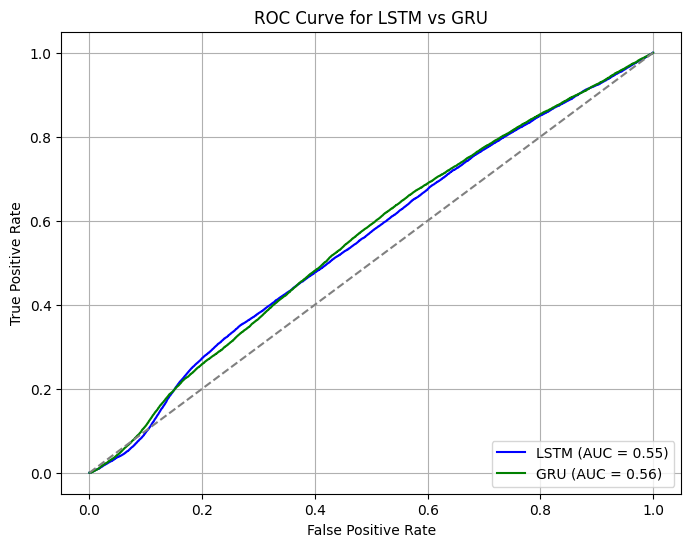

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Combine normal and anomaly errors
lstm_errors = np.concatenate([lstm_normal_errors, lstm_anomaly_errors])
gru_errors = np.concatenate([gru_normal_errors, gru_anomaly_errors])

# Create labels: 0 = normal, 1 = anomaly
labels = np.concatenate([np.zeros(len(lstm_anomaly_errors)), np.ones(len(lstm_normal_errors))])

# Compute ROC for LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(labels, lstm_errors)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute ROC for GRU
fpr_gru, tpr_gru, _ = roc_curve(labels, gru_errors)
roc_auc_gru = auc(fpr_gru, tpr_gru)

# Plot both ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_gru, tpr_gru, color='green', label=f'GRU (AUC = {roc_auc_gru:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labels and legend
plt.title('ROC Curve for LSTM vs GRU')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()